# First analysis of the raw data

**Goal:** first look at the raw data `all_IMPACT_mutations_180508.txt`. This notebook focus on the analysis of the data feature per feature, and on the different filters applied on the dataset to clean it. The fifth part only will mix different features to study the relation between them.  
This notebook is divided in six parts:
* **1. Filtering the features**: remove the redundant and unique-value features
* **2. Filtering the rows (over the `Consequence` feature)**: remove the non-studied mutation types
* **3. Study of the sequencing read features**: contamination, depth, vaf, count...
* **4. Study of other interesting features**
* **5. Contingency tables**: study of the contingency tables between the three features `Consequence`, `confidence_class` and `Variant_Type`
* **6. Resume of the operations needed to clean the dataset**

**Main results:** (after the cleaning)
* **248,293** mutations (synonymous included, they represent $\approx 20.1\%$ of the dataset)
* **22990** tumor samples (mean of $\approx 10.8\%$ called mutations per tumor sample)
* **21,252** patients
* **475** genes
* Mean sample coverage: **722**

**Refs:**
* [FirstLook.Rmd [Elsa]](
https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180510_elsa/FirstLook.Rmd)
* `first_analysis_unsolved_issues.ipynb`

***

In [108]:
%run custom_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [109]:
impact = pd.read_csv('../../data/all_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

In [34]:
impact.shape

(588547, 35)

## Filtering the features

In [35]:
#!! str(impact)

### Unique-value features 
We inspect the features that share a unique value accross the dataset, and remove them.

In [36]:
count_per_feature = impact.nunique() # get number of unique values per feature
count_per_feature.head()

Hugo_Symbol       615
Entrez_Gene_Id      1
Center              1
NCBI_Build          1
Chromosome         23
dtype: int64

In [37]:
unique_value_features = count_per_feature[count_per_feature == 1].index.tolist()
print(unique_value_features)

['Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Strand', 'dbSNP_RS', 'variant_status']


In [38]:
print(impact[unique_value_features].iloc[0])                 # let's inspect these unique values
impact.drop(unique_value_features, axis = 1, inplace = True) # and remove them

Entrez_Gene_Id              0
Center             MSK-IMPACT
NCBI_Build               hg19
Strand                      +
dbSNP_RS                novel
variant_status    NEW_VARIANT
Name: 0, dtype: object


### Redundant feature
We remove the redundant features.

In [39]:
any(impact.Match_Norm_Seq_Allele1 != impact.Match_Norm_Seq_Allele2)
any(impact.Reference_Allele       != impact.Tumor_Seq_Allele1)
any(impact.Reference_Allele       != impact.Match_Norm_Seq_Allele1)
impact.drop(['Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Seq_Allele1'], axis = 1, inplace = True)

In [40]:
impact.shape[1] # 35 before

26

## Filtering the rows (over the `Consequence` feature)

Let's study the number of rows for each `Consequence` value:

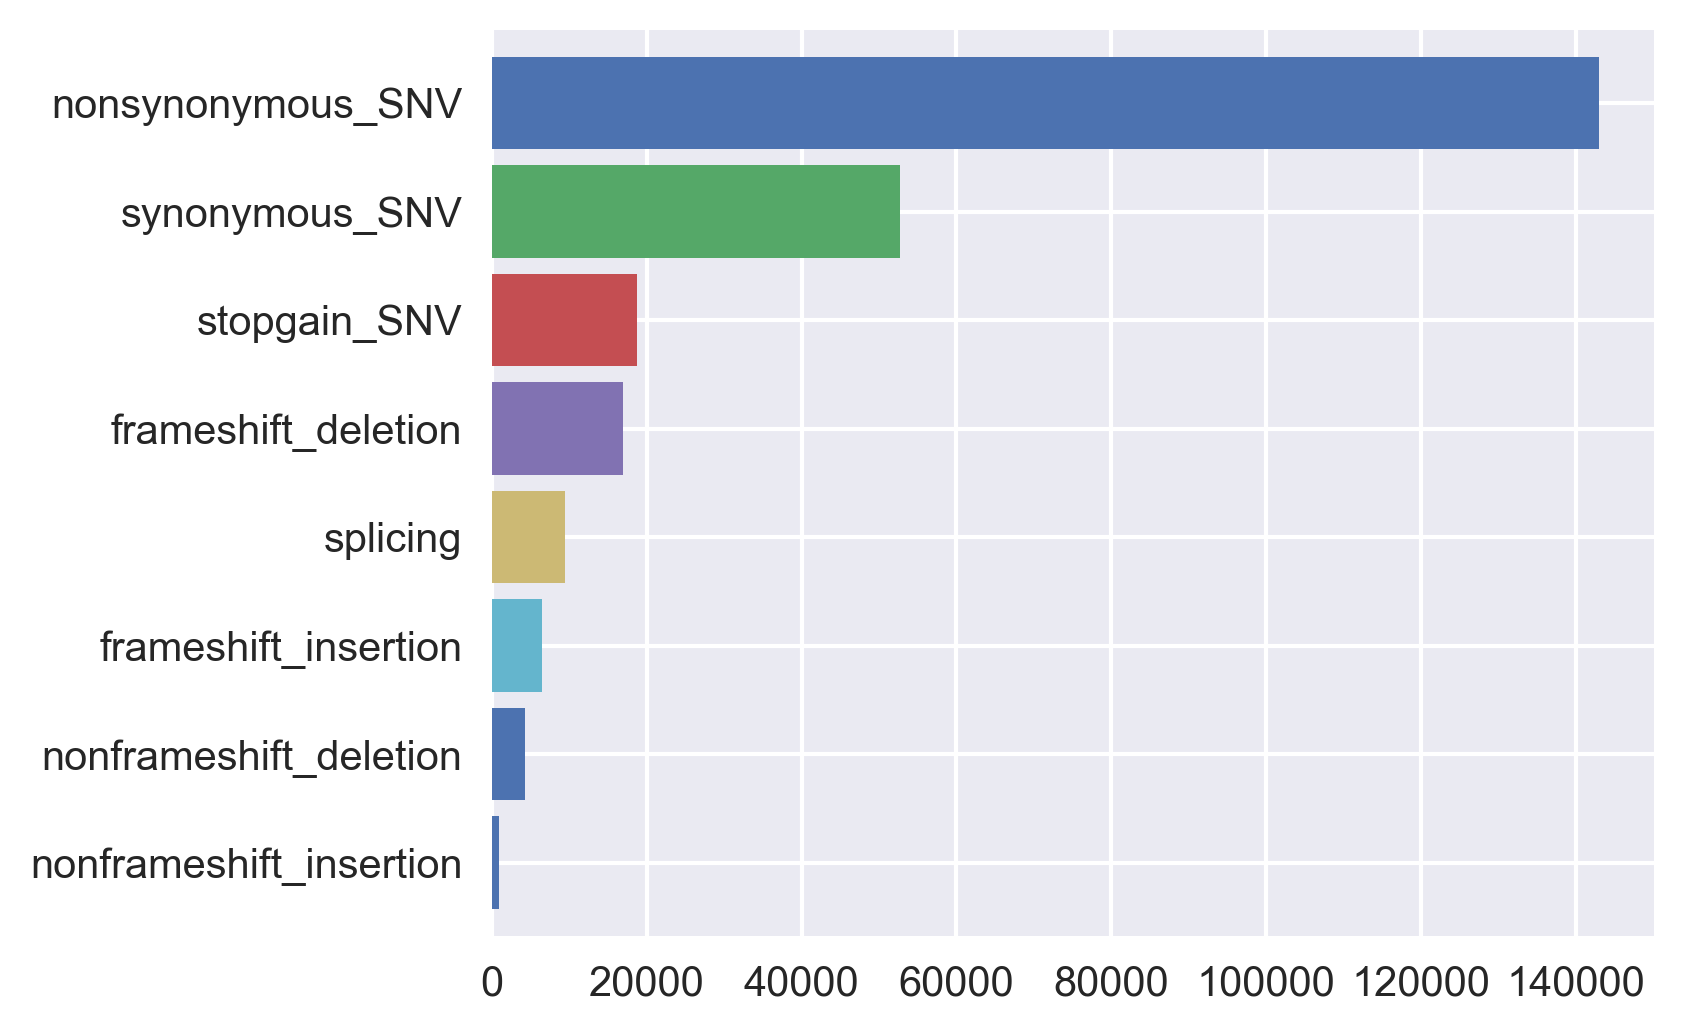

In [67]:
impact.Consequence.value_counts().plot(kind = 'barh', width = 0.85, figsize = (5, 4)).invert_yaxis()

We will only work on the following mutation types:

In [42]:
selected_mutation_types = ['stopgain_SNV',
                           'splicing',
                           'nonsynonymous_SNV',
                           'nonframeshift_insertion',
                           'nonframeshift_deletion',
                           'frameshift_insertion',
                           'frameshift_deletion',
                           'synonymous_SNV']

impact = impact[impact.Consequence.isin(selected_mutation_types)]

In [43]:
get_table(impact.Consequence) # from custom_tools.py

,count_,freq_
nonsynonymous_SNV,149690,56.3%
synonymous_SNV,56517,21.3%
stopgain_SNV,19594,7.4%
frameshift_deletion,17659,6.6%
splicing,9900,3.7%
frameshift_insertion,6834,2.6%
nonframeshift_deletion,4557,1.7%
nonframeshift_insertion,1000,0.4%


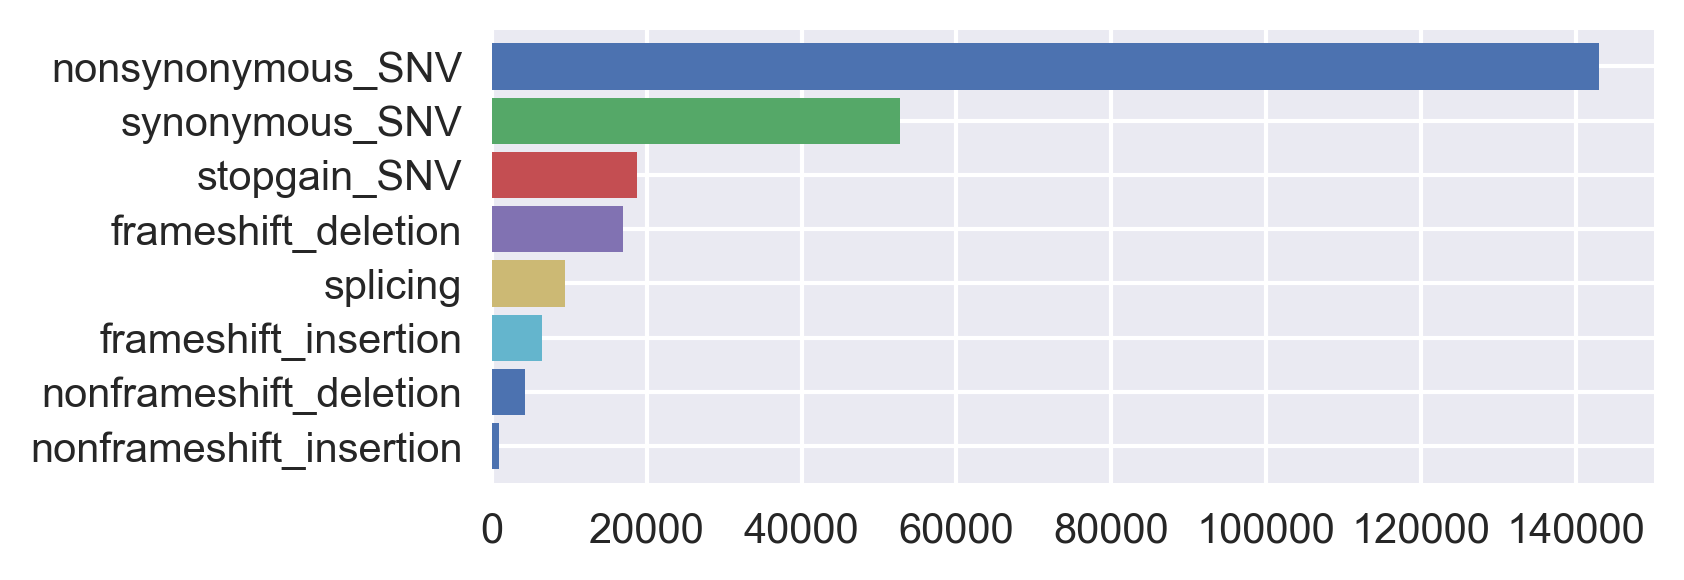

In [68]:
impact.Consequence.value_counts().plot(kind = 'barh', width = 0.85, figsize = (5, 2)).invert_yaxis()

In [69]:
impact.shape[0] # it was 588,547 before

252776

## Study of the sequencing read features

### `minor_contamination`

From `FirstLook.Rmd [Elsa]`: "I quote Ahmet: minor_contamination : this is our calculation of presence of possible another sample in the tumor. This should be less than or equal to 0.01."

In [70]:
print_count(sum(impact.minor_contamination > 0.01), impact.shape[0]) # from custom_tools.py

AttributeError: 'DataFrame' object has no attribute 'minor_contamination'

In [71]:
impact = impact[impact.minor_contamination <= 0.01]          # we can remove these rows, it represents 5% of the data
impact.drop('minor_contamination', axis = 1, inplace = True) # we remove the feature

AttributeError: 'DataFrame' object has no attribute 'minor_contamination'

### `t_depth`, `n_depth`

In [48]:
impact[['t_depth', 'n_depth']].describe()

,t_depth,n_depth
count,252776.000000,252776.000000
mean,720.910502,525.572515
std,616.652920,242.359918
min,20.000000,0.000000
25%,458.000000,361.000000
50%,658.000000,497.000000
75%,893.000000,659.000000
max,47147.000000,20966.000000


/Users/pierreguilmin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pierreguilmin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


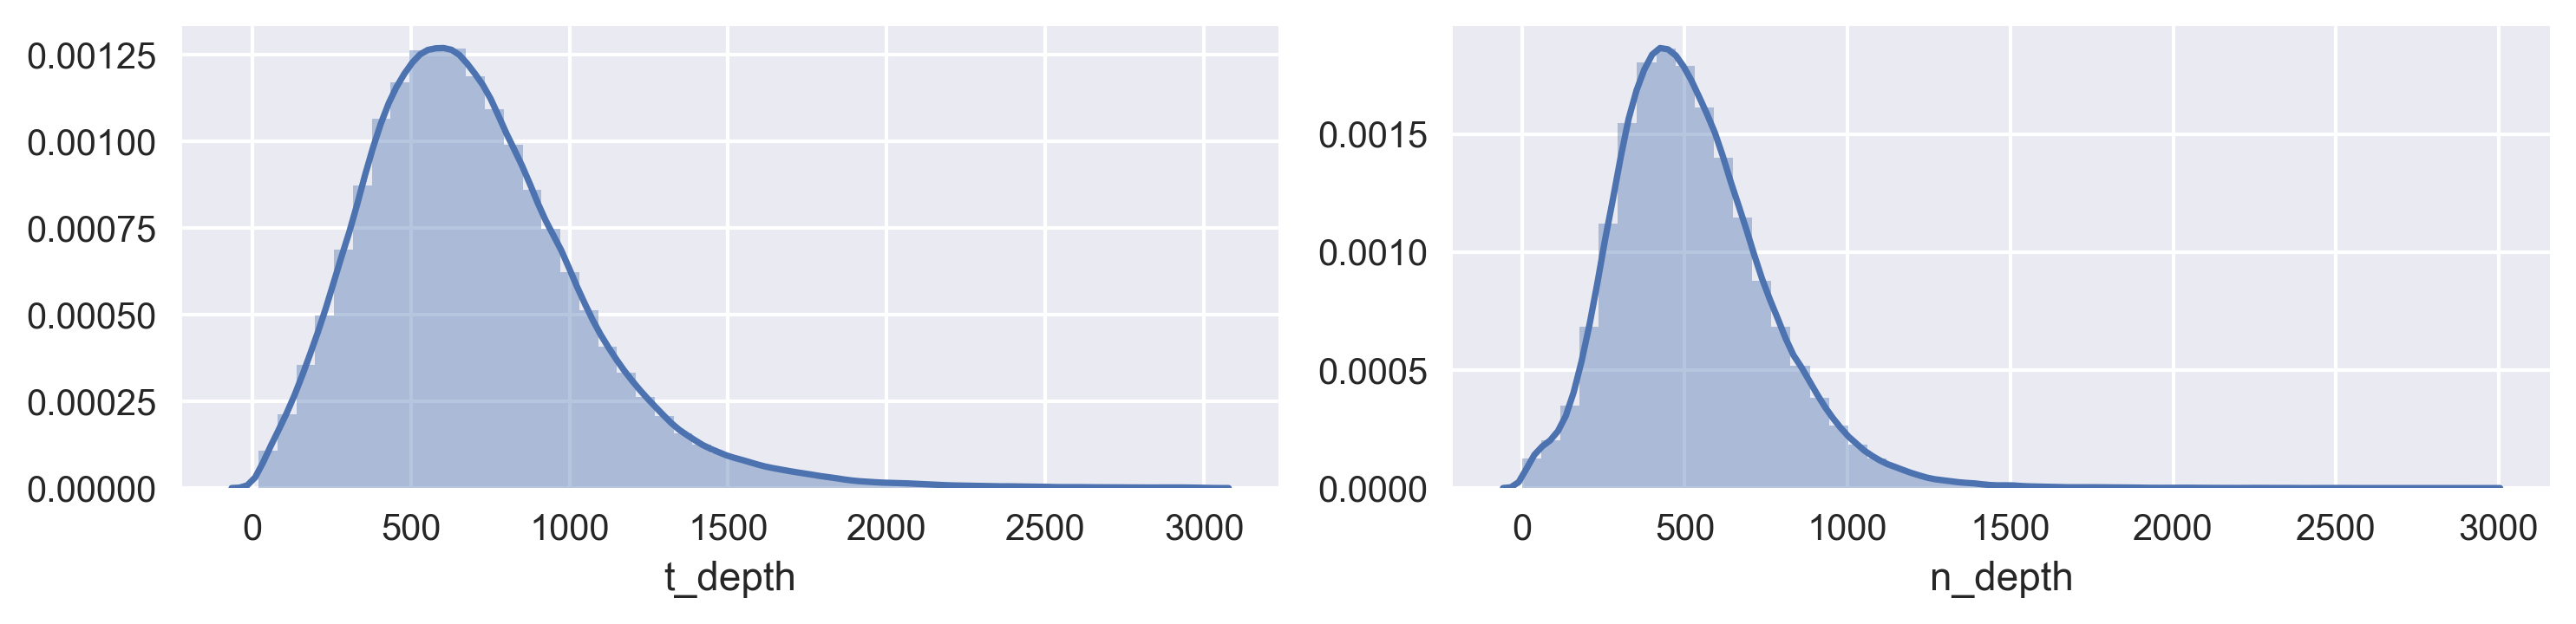

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 2.5))
sns.distplot(impact.t_depth[impact.t_depth < 3000], ax = ax1)
sns.distplot(impact.n_depth[impact.n_depth < 3000], ax = ax2);

The overall repartition seems satisfying with the means being $> 500$ reads for both `t_depth` and `n_depth`. We notice that the minimum value for `t_depth` is 20, maybe a threshold has been set (and probably a threshold on the `t_act_count` feature studied later).  

<font color='red'> ?? There is something weird with some rows having 0 or really a low `n_depth` reads, see `first_analysis_unsolved_issues.ipynb` for more information.  
**Decision:** we decided to set a threshold for `n_depth`, every row with `n_depth < 20` is removed (20 being the `t_depth` min value), ie 373 rows. </font>

In [88]:
get_table(impact.Hugo_Symbol[impact.t_depth >= 10000])

,count_,freq_
EGFR,117,65.4%
CCNE1,12,6.7%
PDGFRA,12,6.7%
ERBB2,8,4.5%
FGFR2,6,3.4%
PIK3CA,4,2.2%
MDM2,3,1.7%
AR,2,1.1%
GLI1,2,1.1%
MET,2,1.1%


And we have 178 rows having more than 10,000 `t_depth` reads:

In [18]:
get_simple_table(impact$Hugo_Symbol[impact$t_depth >= 10000])

data
  EGFR PDGFRA  CCNE1  ERBB2  FGFR2 PIK3CA   MDM2    MET   GLI1     AR   YES1 
   117     12     12      8      6      4      3      2      2      2      1 
  SOS1  PRDM1   MYCN   KRAS  IGF1R   FGF4  EPCAM  CCND2  BRIP1  ASXL1    Sum 
     1      1      1      1      1      1      1      1      1      1    179 

The genes concerned are mostly oncogenes known for their high replication rate (see EGFR or ERBB2), these values are thus not so surprising.

### `t_vaf`, `n_vaf`

In [89]:
impact[['t_depth', 'n_depth']].describe()

,t_depth,n_depth
count,252392.000000,252392.000000
mean,721.856434,526.356473
std,616.430291,241.708661
min,20.000000,20.000000
25%,459.000000,361.000000
50%,659.000000,497.000000
75%,894.000000,660.000000
max,47147.000000,20966.000000


/Users/pierreguilmin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pierreguilmin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


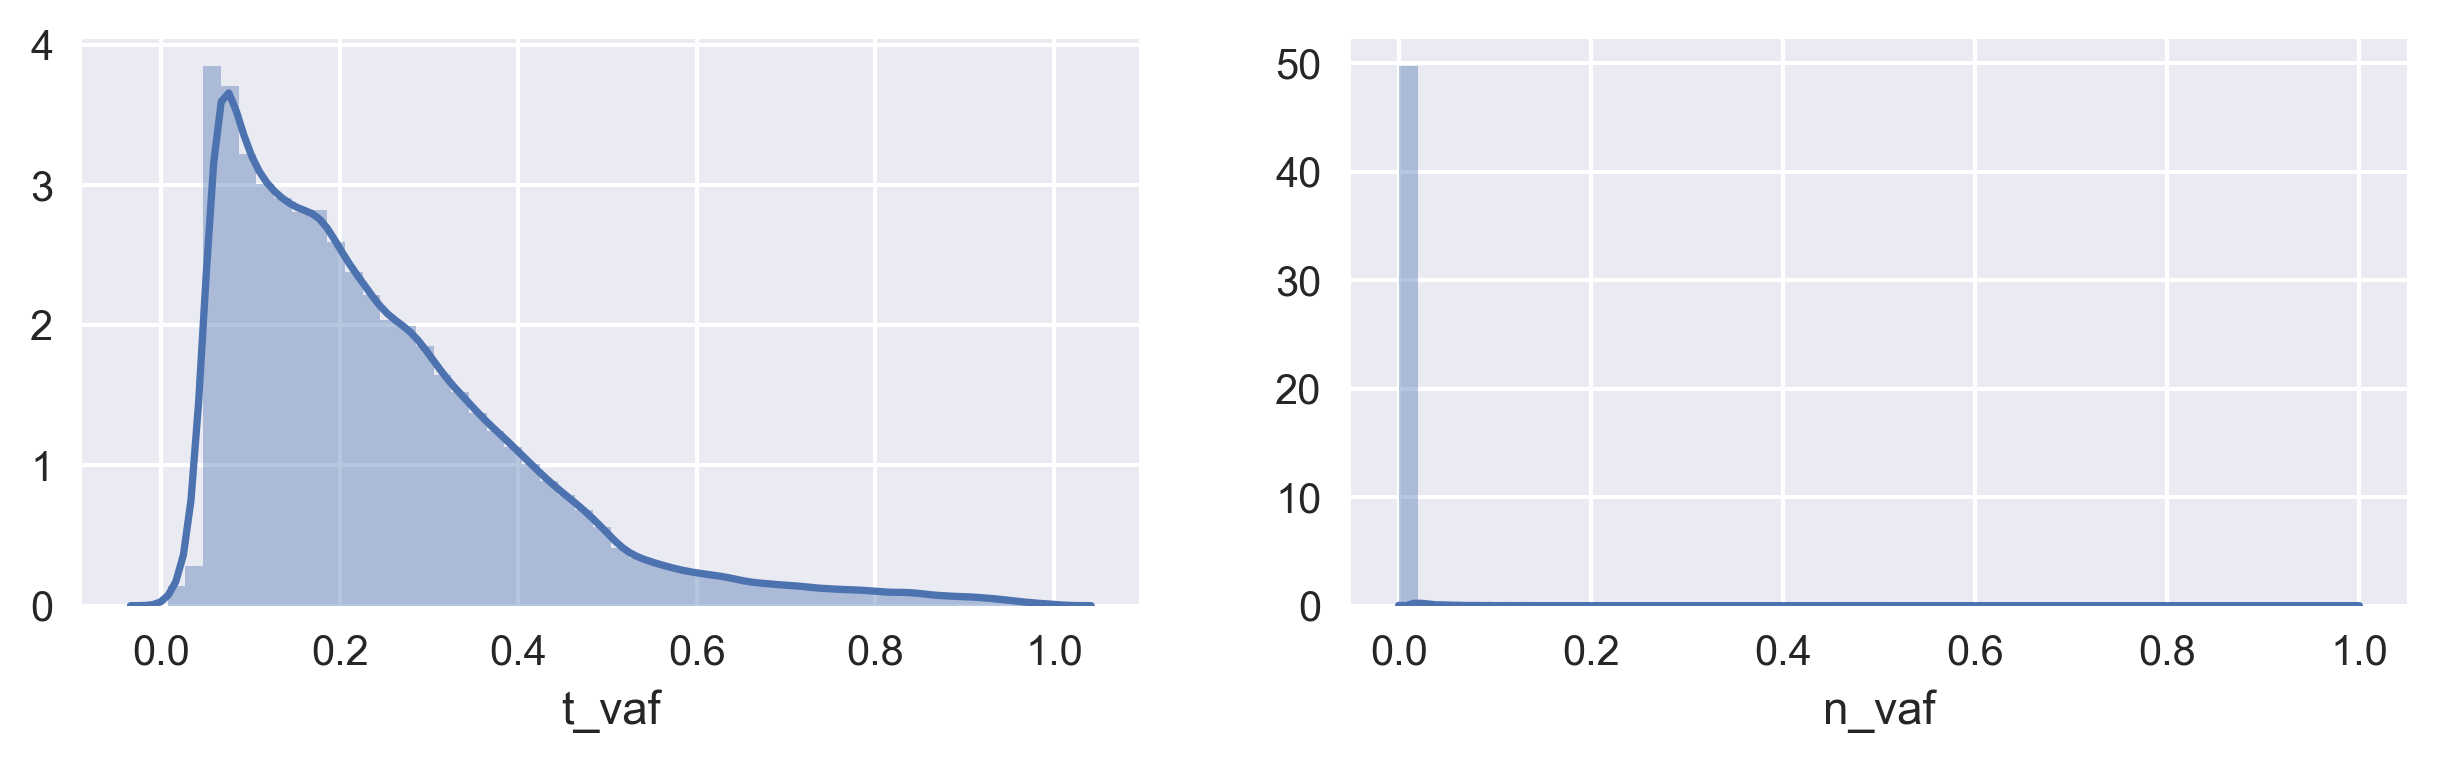

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 2.5))
sns.distplot(impact.t_vaf, ax = ax1)
sns.distplot(impact.n_vaf, ax = ax2);

<font color='red'> ?? Some `n_vaf` values are really huge, see `first_analysis_unsolved_issues.ipynb` for more information.  
**Decision:** The decision has been taken to keep all these mutations, as they represent a good filtering feature for the somatic/non-somatic classifier, see plot after, most of the mutations having a high `n_vaf` have been classified as `UNLIKELY`. </font>

### `t_alt_count`, `n_alt_count`

We want to verify that the two quantities `t_alt_count / t_depth` and `t_vaf` are equals. Because `t_vaf` is rounded, we will evaluate if the absolute difference between this two quantities is $<0.01$, and consider them as equal if so.  
The same work is done with `n_alt_count / n_depth` and `n_vaf`.

In [21]:
abs_diff_t_vaf <- abs(impact$t_alt_count / impact$t_depth - impact$t_vaf)
abs_diff_n_vaf <- abs(impact$n_alt_count / impact$n_depth - impact$n_vaf)

table(abs_diff_t_vaf >= 0.01)
table(abs_diff_n_vaf >= 0.01)


 FALSE 
252392 


 FALSE 
252392 

### `t_alt_plus_count`, `t_alt_neg_count`

In [22]:
wrong_t_alt_count <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count,]
nrow(wrong_t_alt_count)

[1] 46

46 rows have `t_alt_plus_count + t_alt_neg_count != t_alt_count`. We will quantify this error by computing the absolute difference between these two values:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0   102.8   238.0   463.4   311.0 10447.0 

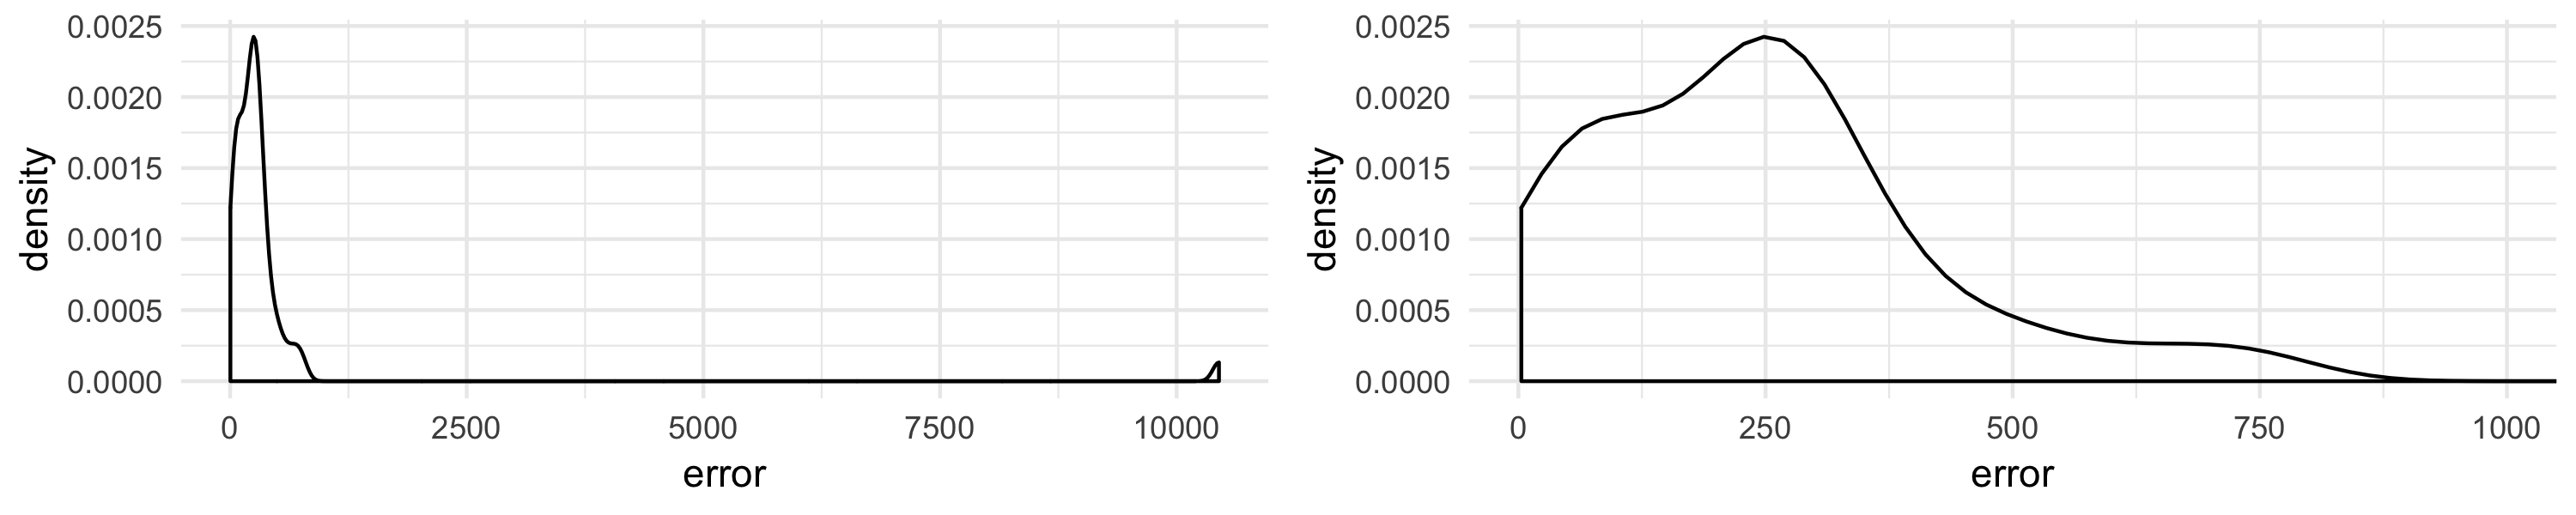

In [23]:
wrong_t_alt_count$error <- abs(wrong_t_alt_count$t_alt_plus_count + wrong_t_alt_count$t_alt_neg_count -
                               wrong_t_alt_count$t_alt_count)

summary(wrong_t_alt_count$error)
plot1 <- plot_density(wrong_t_alt_count, "error")
plot2 <- plot_density(wrong_t_alt_count, "error") + coord_cartesian(xlim = c(0, 1000))
plot_side_by_side(plot1, plot2)

The difference is not negligible, with a median $>207$, we decided to remove these 46 rows (see under for further study of these points).

In [24]:
impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,] # remove these rows

#### Futher analysis

The following plot (`x = t_alt_plus_count + t_alt_neg_count`, `y = t_alt_count`) shows the distribution of the values around the line $y = x$, where they should lie (ie `t_alt_plus_count + t_alt_neg_count = t_alt_count`).

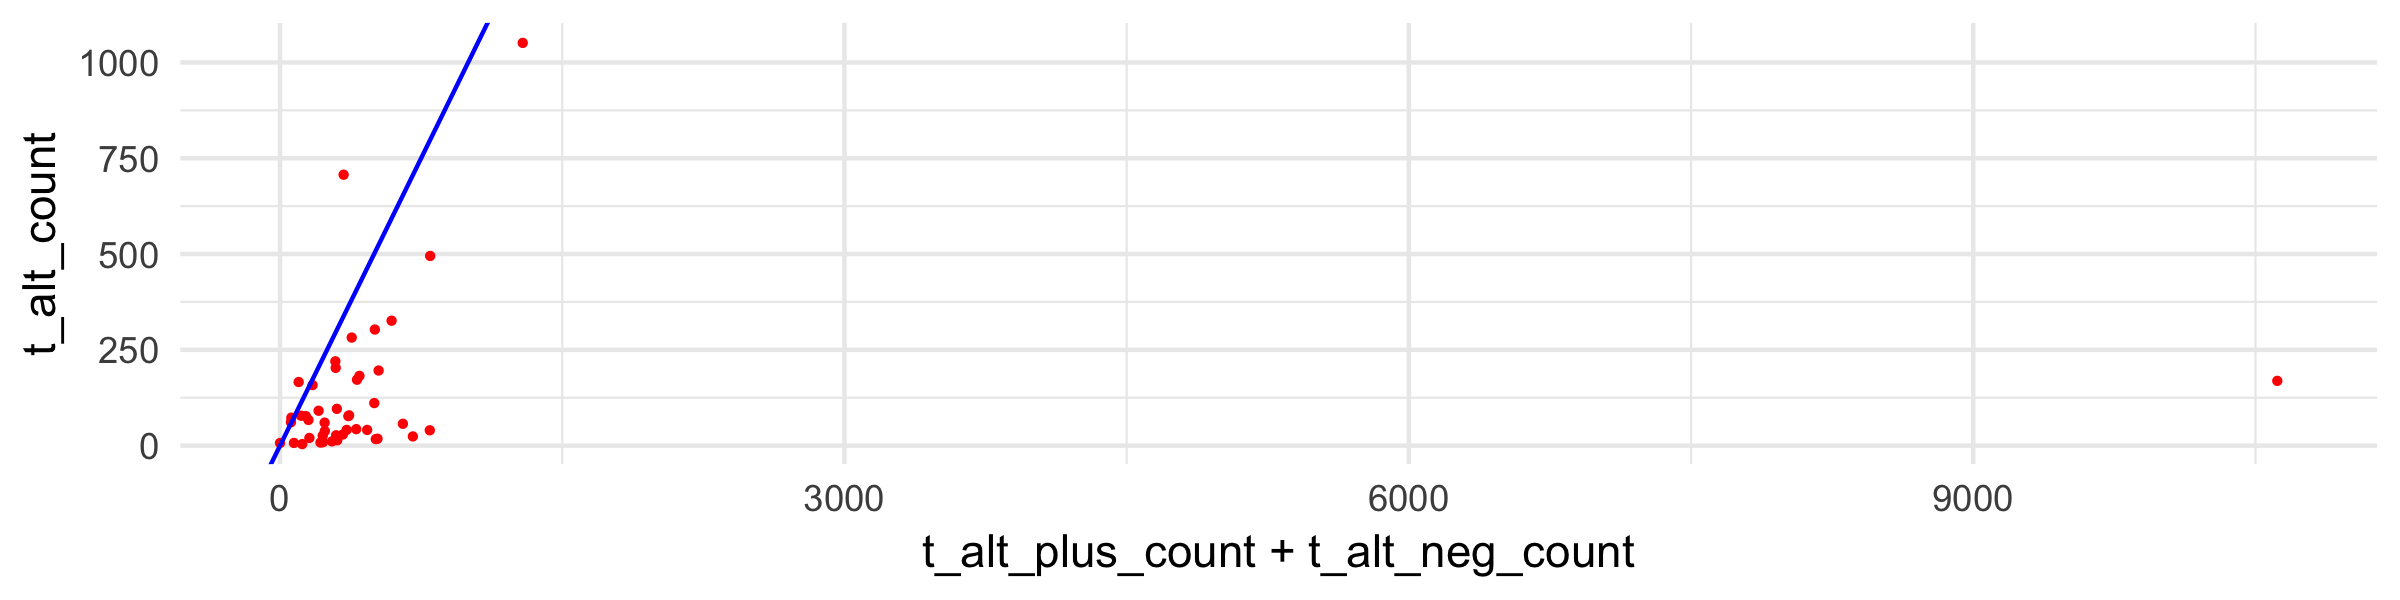

In [25]:
notebook_plot_size(8, 2)
ggplot(wrong_t_alt_count) +
        geom_point(aes(x = t_alt_plus_count + t_alt_neg_count, y = t_alt_count), size = 0.5, color = "red") +
        geom_abline(intercept = 0, slope = 1, color ="blue")

These rows seems to have a usual `t_vaf`, they don't seem to have a special gene, `Consequence` or `Variant_Type` features, and most of them are nonsynonymous mutations curated as somatic (see under):

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00700 0.04051 0.11649 0.18046 0.29943 0.73646 

[1] "Number of different genes:  31"


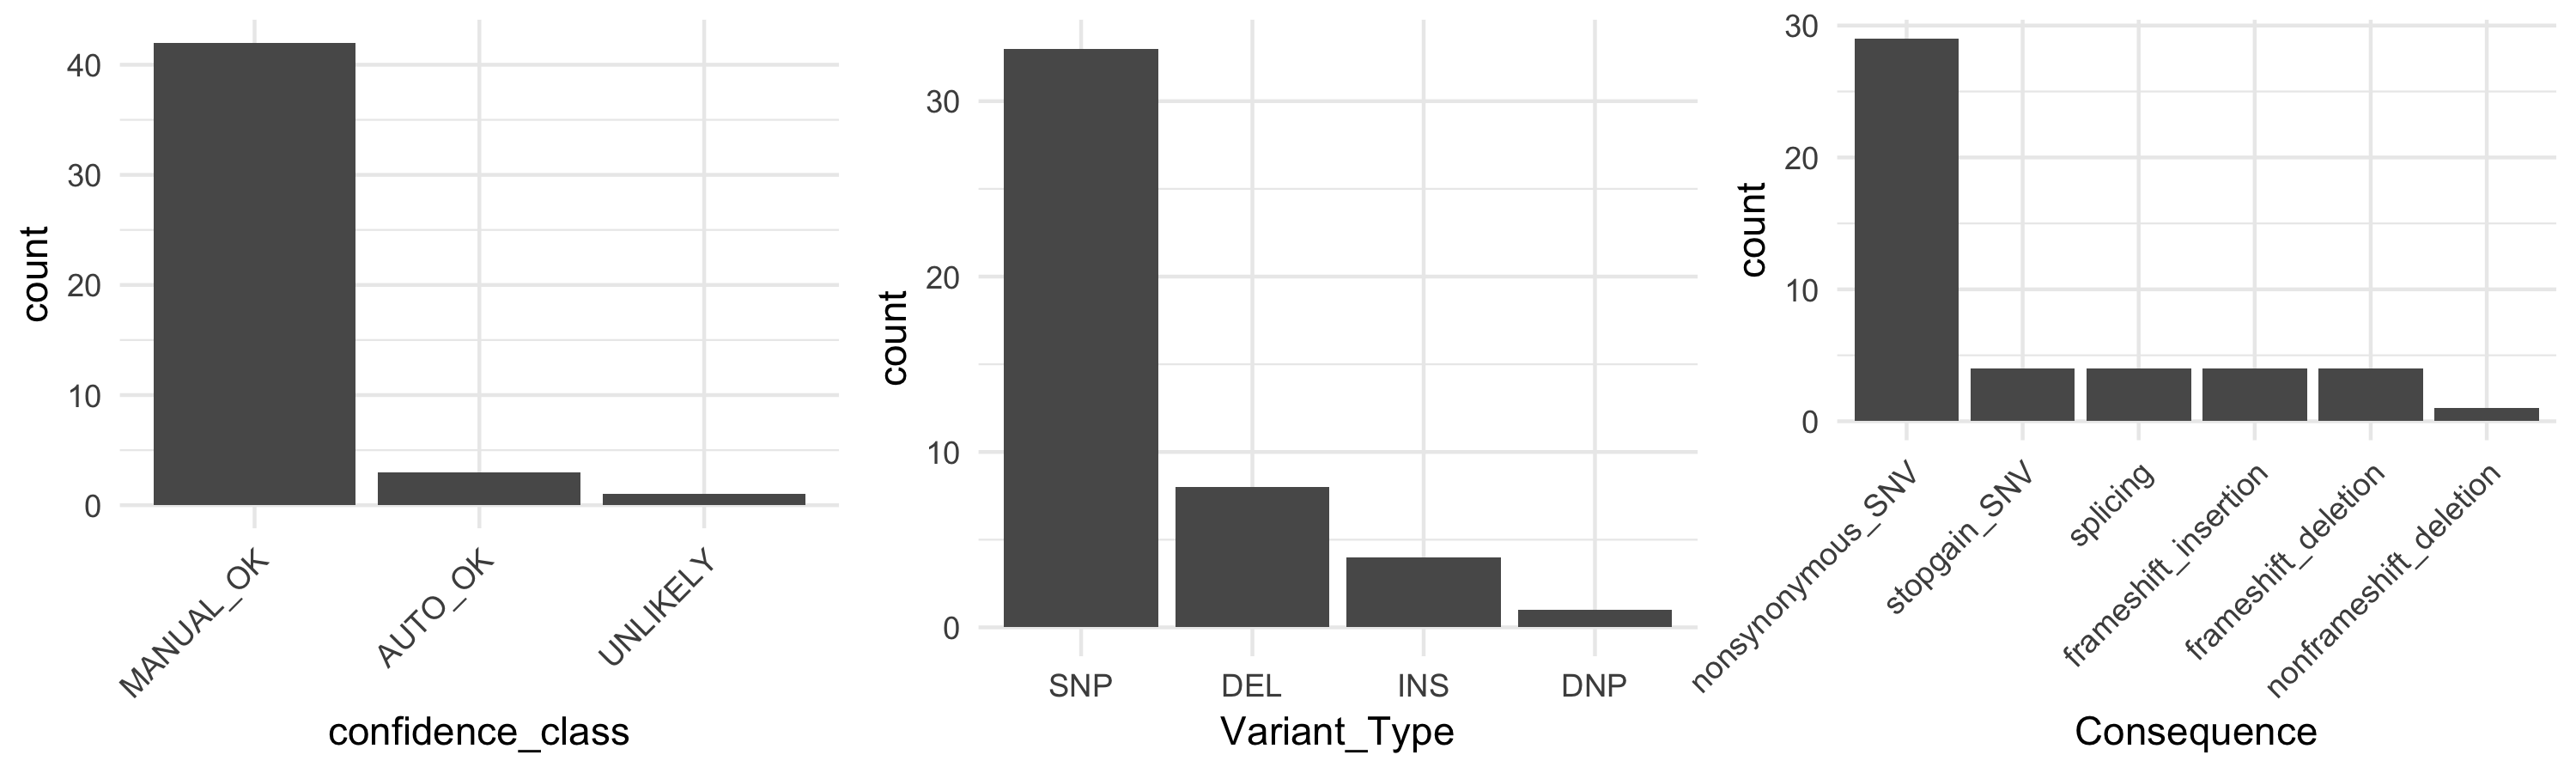

In [26]:
summary(wrong_t_alt_count$t_vaf)
get_possible_correlations(wrong_t_alt_count)

## Study of other interesting features

### Create the `mut_key` and `sample_mut_key` features

We create the `mut_key` feature (mutation key) that identifies unique mutations, and will be thoroughly used in the rest of the study. The mutation key is defined as `Chromosome` _ `Start_Position` _ `Reference_Allele` _ `Tumor_Seq_Allele2`.

In [27]:
impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
head(impact$mut_key)

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

<font color='red'> ?? There is something weird with some `mut_key` having different values for `Consequence`, `cDNA_change` or `HGVSp_Short`, see `first_analysis_unsolved_issues.ipynb` for more information.  
**Decision:** The decision has been made to modify the inconsistent features and sometimes, only when necessary, to remove the mutations. Every `mut_key` is now consistent (ie has one unique value) for the `Consequence` and `HGVSp_Short` features. The `cDNA_change` feature was not modified because we won't study it in the rest of our work, and some `mut_key` are thus still inconsistent on this feature. The modification are present in the last summary part.</font>

We create the `sample_mut_key` feature (sample mutation key) that identifies unique rows in the dataset, and will be thoroughly used in the rest of the study. The sample mutation key is defined as `Tumor_Sample_Barcode`_`mut_key`.

In [28]:
impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')
head(impact$sample_mut_key)

[1] "P-0000012-T02-IM3_17_7577515_T_G"  "P-0000012-T02-IM3_1_27101572_C_G" 
[3] "P-0000012-T02-IM3_19_5244030_C_G"  "P-0000012-T03-IM3_1_46521514_G_C" 
[5] "P-0000012-T03-IM3_3_142178126_C_A" "P-0000012-T03-IM3_4_55139732_T_A"

### `Hugo_Symbol`

Unfortunately there are some wrong/synonymous `Hugo_Symbol`. We use the [symbol checker tool](https://www.genenames.org/cgi-bin/symbol_checker) of the website HGNC (HUGO Gene Nomenclature Committee) to correct the errors, we give the result of `unique(impact$Hugo_Symbol)` to the symbol checker tool, and check which symbols are wrong/synonymous. Any incertitude was double ckecked with [OncoKB](http://oncokb.org/#/). Based on the results, the following 18 symbols were found to be unofficial:

| Old Hugo Symbol  | New Hugo symbol | HGNC reason     | Count |
| ---------------- | --------------- | --------------- | ----- |
| MLL3             | KMT2C           | Previous symbol | 1380  |
| PAK7             | PAK5            | Previous symbol | 924   |
| RFWD2            | COP1            | Previous symbol | 349   |
| MYCL1            | MYCL            | Previous symbol | 176   |
| MLL2             | KMT2D           | Previous symbol | 1948  |
| MLL              | KMT2A           | Previous symbol | 744   |
| FAM46C           | TENT5C          | Previous symbol | 231   |
| MRE11A           | MRE11           | Previous symbol | 313   |
| PARK2            | PRKN            | Previous symbol | 392   |
| FAM175A          | ABRAXAS1        | Previous symbol | 124   |
| TCEB1            | ELOC            | Previous symbol | 40    |
| WHSC1            | NSD2            | Previous symbol | 305   |
| WHSC1L1          | NSD3            | Previous symbol | 273   |
| FAM58A           | CCNQ            | Previous symbol | 104   |
| SETD8            | KMT5A           | Previous symbol | 106   |
| MLL4             | KMT2B           | Synonyms        | 92    |
| CDKN2Ap16INK4A   | CDKN2A          | Unmatched       | 1334  |
| CDKN2Ap14ARF     | CDKN2Ap14ARF    | Unmatched       | 865   |

We decided to rename every symbols that are classified as "Previous Symbol" and "Synonyms" (see first header). The processus applied to rename `CDKN2Ap16INK4A` and `CDKN2Ap14ARF` is detailed just after (see second header).

#### Renaming the "Previous Symbol" and "Synonyms"

In [29]:
old_Hugo_Symbol = c('MLL3', 'PAK7', 'RFWD2', 'MYCL1', 'MLL2', 'MLL', 'FAM46C', 'MRE11A', 'PARK2', 'FAM175A',
                    'TCEB1', 'WHSC1', 'WHSC1L1', 'FAM58A', 'SETD8', 'MLL4')
new_Hugo_Symbol = c('KMT2C', 'PAK5', 'COP1', 'MYCL', 'KMT2D', 'KMT2A', 'TENT5C', 'MRE11', 'PRKN', 'ABRAXAS1',
                    'ELOC', 'NSD2', 'NSD3', 'CCNQ', 'KMT5A', 'KMT2B')

old_symbols <- which(impact$Hugo_Symbol %in% old_Hugo_Symbol)
length(impact$Hugo_Symbol[old_symbols]) # 7477 previous/synonyms symbols!
head(impact$Hugo_Symbol[old_symbols])

[1] 7477

[1] "MLL3"  "PAK7"  "RFWD2" "MYCL1" "MLL3"  "MLL3"

In [30]:
# Replace the old Hugo Symbol by the new Hugo Symbol
impact$Hugo_Symbol[old_symbols] <- new_Hugo_Symbol[match(impact$Hugo_Symbol[old_symbols], old_Hugo_Symbol)]
length(impact$Hugo_Symbol[impact$Hugo_Symbol %in% old_Hugo_Symbol])
head(impact$Hugo_Symbol[old_symbols]) # the old symbols have been replaced by the new ones

[1] 0

[1] "KMT2C" "PAK5"  "COP1"  "MYCL"  "KMT2C" "KMT2C"

#### `CDKN2Ap16INK4A` and `CDKN2Ap14ARF`

The symbole checker tool detected two symbols as "Unmatched", `CDKN2Ap16INK4A` and `CDKN2Ap14ARF`. These two symbols correspond to two different reading frame of the gene `CDKN2A`:
* `CDKN2Ap16INK4A` is the "classic" reading frame for `CDKN2A`, the one used by OncoKB (see [OncoKB CDKN2A](http://oncokb.org/#/gene/CDKN2A))  
   → RefSeq. NM_000077.4  
   → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 1, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_000077.4)  
   → [Wikipedia article p16](https://en.wikipedia.org/wiki/P16)
* `CDKN2Ap14ARF` is an Alternative Reading Frame (ARF, as said in its name) for `CDKN2A`, not used by OncoKB  
  → RefSeq. NM_058195.3  
  → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 4, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_058195)  
  → [Wikipedia article p14arf](https://en.wikipedia.org/wiki/P14arf)
  
We decided to replace every `CDKN2Ap16INK4A` by `CDKN2A`. We also decided to keep the name `CDKN2Ap14ARF` for the alternative reading frame, except when the mutation was already included in the classic reading frame (in `CDKN2Ap16INK4A`), then we delete the mutation because it has already been read in the classic reading frame.

In [31]:
impact$Hugo_Symbol[impact$Hugo_Symbol == "CDKN2Ap16INK4A"] <- "CDKN2A" # replace CDKN2Ap16INK4A by CDKN2A

In [32]:
is_classic_CDKN2A <- which(impact$Hugo_Symbol == "CDKN2A")

# number of mutations read in the alternative frame but already read in the classic frame -> to remove!
nrow(impact %>% filter(Hugo_Symbol == "CDKN2Ap14ARF" &
                       mut_key %in% impact$mut_key[is_classic_CDKN2A]))

# number of mutations read in the alternative frame but not in the classic frame
nrow(impact %>% filter(Hugo_Symbol == "CDKN2Ap14ARF" &
                       ! (mut_key %in% impact$mut_key[is_classic_CDKN2A])))

[1] 808

[1] 57

We delete from `impact` the rows that are `CDKN2Ap14ARF` and have already been read in the classic reading frame:

In [33]:
# remove the 808 repeated rows
impact <- impact %>% filter(! (Hugo_Symbol == "CDKN2Ap14ARF" &
                               mut_key %in% impact$mut_key[is_classic_CDKN2A]))

In [34]:
length(unique(impact$Hugo_Symbol)) # number of different genes

[1] 475

### `Chromosome`

In [35]:
length(unique(impact$Chromosome)) # number of different chromosomes

[1] 23

### `Tumor_Sample_Barcode`

#### Number of mutations per sample

We construct a dataframe giving the number of mutations per sample:

In [36]:
tumor_summary <- as.data.frame(table(impact$Tumor_Sample_Barcode))
colnames(tumor_summary) <- c("Tumor_Sample_Barcode", "number_of_mutations")
tail(tumor_summary)

,Tumor_Sample_Barcode,number_of_mutations
22989,P-0029283-T01-IM6,2
22990,P-0029284-T01-IM6,5
22991,P-0029285-T01-IM6,6
22992,P-0029286-T01-IM6,2
22993,P-0029287-T01-IM6,4
22994,P-0029288-T01-IM6,7


In [37]:
nrow(tumor_summary)
summary(tumor_summary$number_of_mutations)

[1] 22994

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00    5.00   10.94    9.00 2979.00 

So we have a mean of 11 called mutations per tumor sample, among **22994 tumor sample**. The distribution of mutations is really tight (see under), with a few outliers having a high mutational burden. Indeed, 254 samples presented more than a 100 mutations (e.g. $254/23000\approx1.1\%$ of the sample), but only one sample presented more than 800 mutations.

[1] 254

[1] 1

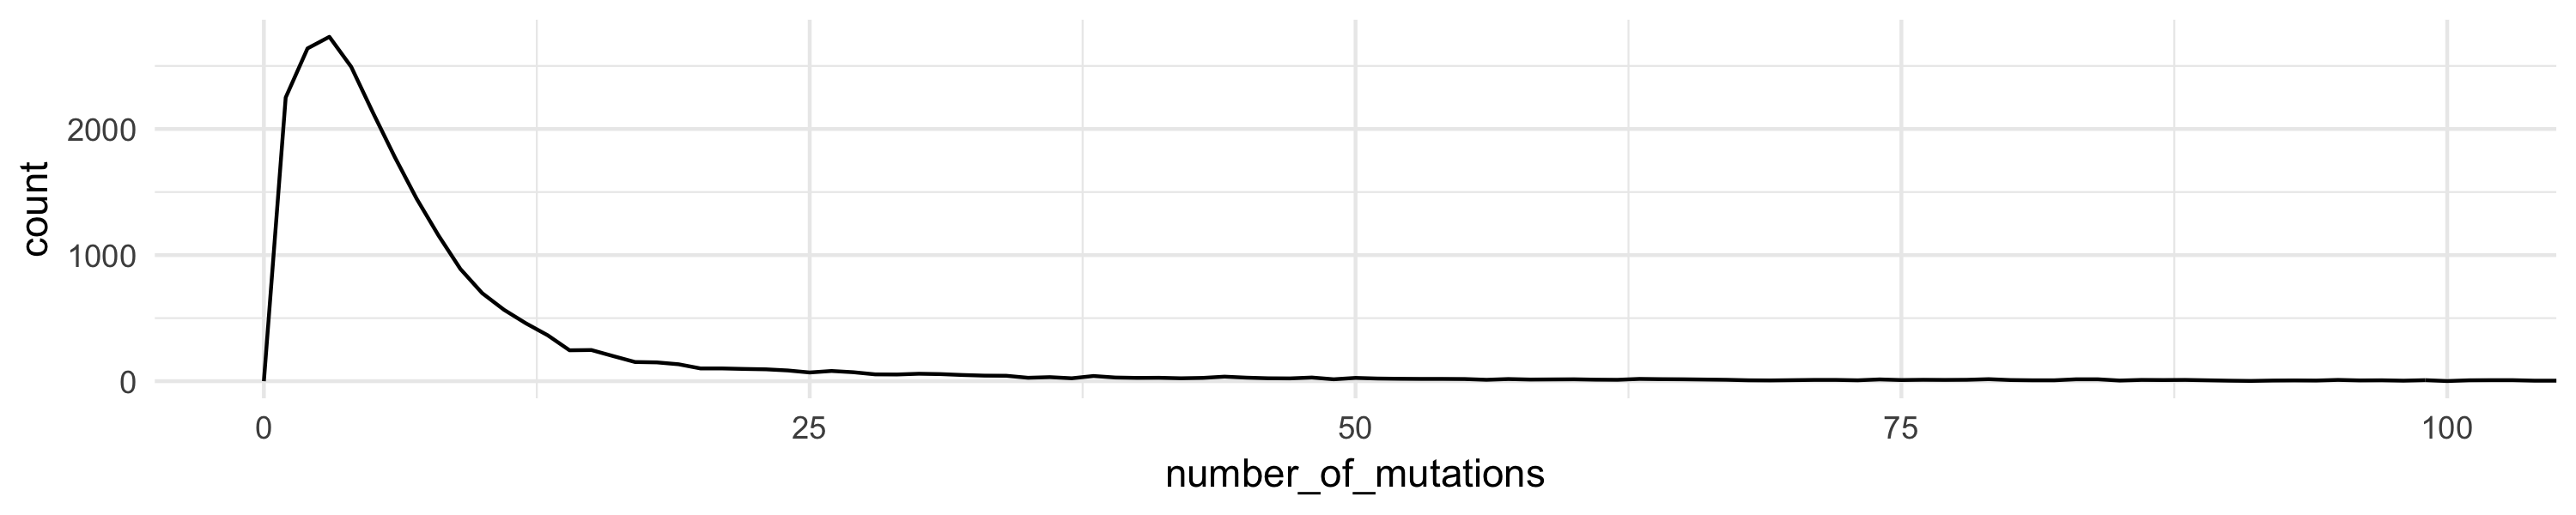

In [38]:
nrow(tumor_summary[tumor_summary$number_of_mutations >= 100,])
nrow(tumor_summary[tumor_summary$number_of_mutations >= 800,])
notebook_plot_size(10, 2)
ggplot(tumor_summary) + geom_freqpoly(aes(number_of_mutations), binwidth = 1) + coord_cartesian(xlim = c(0, 100))

<font color='red'> ?? One of the tumor sample has 2979 mutations, most of them being `synonymous_SNV`, see `first_analysis_unsolved_issues.ipynb` for more information.  
**Decision:** The decision has been taken to remove this patient from the dataset. </font>

In [39]:
impact <- impact[impact$Tumor_Sample_Barcode != "P-0025368-T01-IM6",]

#### Number of patients

Each patient is identified by extracting the 'P-0000012' part of the tumor barcodes, we have **21262 patients**:

In [40]:
length(unique(substr(impact$Tumor_Sample_Barcode, 1, 9)))

[1] 21255

Notice: only one barcode doesn't respect this convention, `None-T01-IM6` with 7 mutations.

In [41]:
# find the not-matching patterns
unique(impact$Tumor_Sample_Barcode[grep("P-", impact$Tumor_Sample_Barcode, invert = TRUE)])
impact[impact$Tumor_Sample_Barcode == "None-T01-IM6",][c("Tumor_Sample_Barcode",
                                                         "Hugo_Symbol",
                                                         "Consequence",
                                                         "Variant_Type",
                                                         "confidence_class")]

[1] "None-T01-IM6"

,Tumor_Sample_Barcode,Hugo_Symbol,Consequence,Variant_Type,confidence_class
203810,None-T01-IM6,TP53,nonsynonymous_SNV,SNP,AUTO_OK
203811,None-T01-IM6,ERBB2,nonsynonymous_SNV,SNP,MANUAL_OK
203812,None-T01-IM6,SMAD4,nonsynonymous_SNV,SNP,AUTO_OK
203813,None-T01-IM6,CDKN2A,nonsynonymous_SNV,SNP,AUTO_OK
203814,None-T01-IM6,CREBBP,nonsynonymous_SNV,SNP,AUTO_OK
203815,None-T01-IM6,TGFBR2,stopgain_SNV,SNP,AUTO_OK


#### Repeated mutations for the same sample

One sample shouldn't have the exact same mutation twice, ie the `sample_mut_key` should be unique accross the dataset. However, 114 samples share the same unique mutations:

In [42]:
impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
nrow(impact_redundant)
head(impact_redundant[order(impact_redundant$sample_mut_key),], 4)

[1] 114

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,mut_key,sample_mut_key
TRAF7,16,2226355,2226355,synonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.1968C>T,p.L656L,91,0.41758,38,88,0,0,28,25,21,17,0,UNKNOWN,1084,16_2226355_C_T,P-0000096-T01-IM3_16_2226355_C_T
TRAF7,16,2226355,2226355,synonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.1968C>T,p.L656L,1210,0.28926,350,296,0,0,381,479,168,182,0,UNKNOWN,1084,16_2226355_C_T,P-0000096-T01-IM3_16_2226355_C_T
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,48,0.22917,11,103,0,0,15,22,5,6,0,UNLIKELY,1084,17_41234541_C_T,P-0000096-T01-IM3_17_41234541_C_T
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,1061,0.27333,290,346,0,0,358,413,128,162,0,AUTO_OK,1084,17_41234541_C_T,P-0000096-T01-IM3_17_41234541_C_T


These rows are all duplicated mutations going two per two, each pair having the same `cDNA_change`, `HGVSp_Short`, `Consequence` and `Variant_Type` features, but some `confidence_class` are different.

In [43]:
impact_redundant %>% group_by(sample_mut_key) %>%
                     summarise(cDNA_change_count  = length(unique(cDNA_change)),
                               HGVSp_Short_count  = length(unique(HGVSp_Short)),
                               Consequence_count  = length(unique(Consequence)),
                               Variant_Type_count = length(unique(Variant_Type))) %>%
                     filter(cDNA_change_count  > 1 |
                            HGVSp_Short_count  > 1 |
                            Consequence_count  > 1 |
                            Variant_Type_count > 1)

sample_mut_key,cDNA_change_count,HGVSp_Short_count,Consequence_count,Variant_Type_count


A quick study shows that the `t_vaf` are relatively close for each pair, we decided to remove in each pair the mutation that have the lowest `t_depth`, to obtain $114/2=57$ mutations:

In [44]:
impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>%
                                                   filter(t_depth == min(t_depth))
nrow(impact_redundant_to_delete)

[1] 60

3 pair of mutations have the same `t_depth`, we remove the one with the lowest `t_vaf`:

In [45]:
impact_redundant_to_delete <- impact_redundant_to_delete %>% group_by(sample_mut_key) %>%
                                                             filter(t_vaf == min(t_vaf))

We delete from `impact` the rows contained in `impact_redundant_to_delete` (and we have to identify them using `sample_mut_key`, `t_depth` and `t_vaf`, annoying duplicated mutations!):

In [46]:
impact <- impact %>% filter(! (sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                               t_depth %in% impact_redundant_to_delete$t_depth &
                               t_vaf %in% impact_redundant_to_delete$t_vaf))

### `confidence_class`

In [47]:
unique(impact$confidence_class)

[1] "AUTO_OK"   "UNKNOWN"   "UNLIKELY"  "MANUAL_OK" "OK_NOT_SO"

From `FirstLook.Rmd [Elsa]`:
* `AUTO_OK` : every variant that enter the database is assign this label.
* `UNKNOWN` : those variants are not curated. Mostly intergenic or synonymous.
* `UNLIKELY` : a curator manually switch the confidence from auto_ok to unlikely, ie to drop.
* `MANUAL_OK` : a curator has been changing his mind ie auto_ok -> drop -> ok.
* `OK_NOT_SO` : a curator dropped the variant too but the variant is higher confidence.  

Let's study the number of rows in each category:

values,count,freq
AUTO_OK,180840,72.8%
UNKNOWN,50015,20.1%
UNLIKELY,10914,4.4%
MANUAL_OK,6387,2.6%
OK_NOT_SO,346,0.1%
-- total --,248502,100%


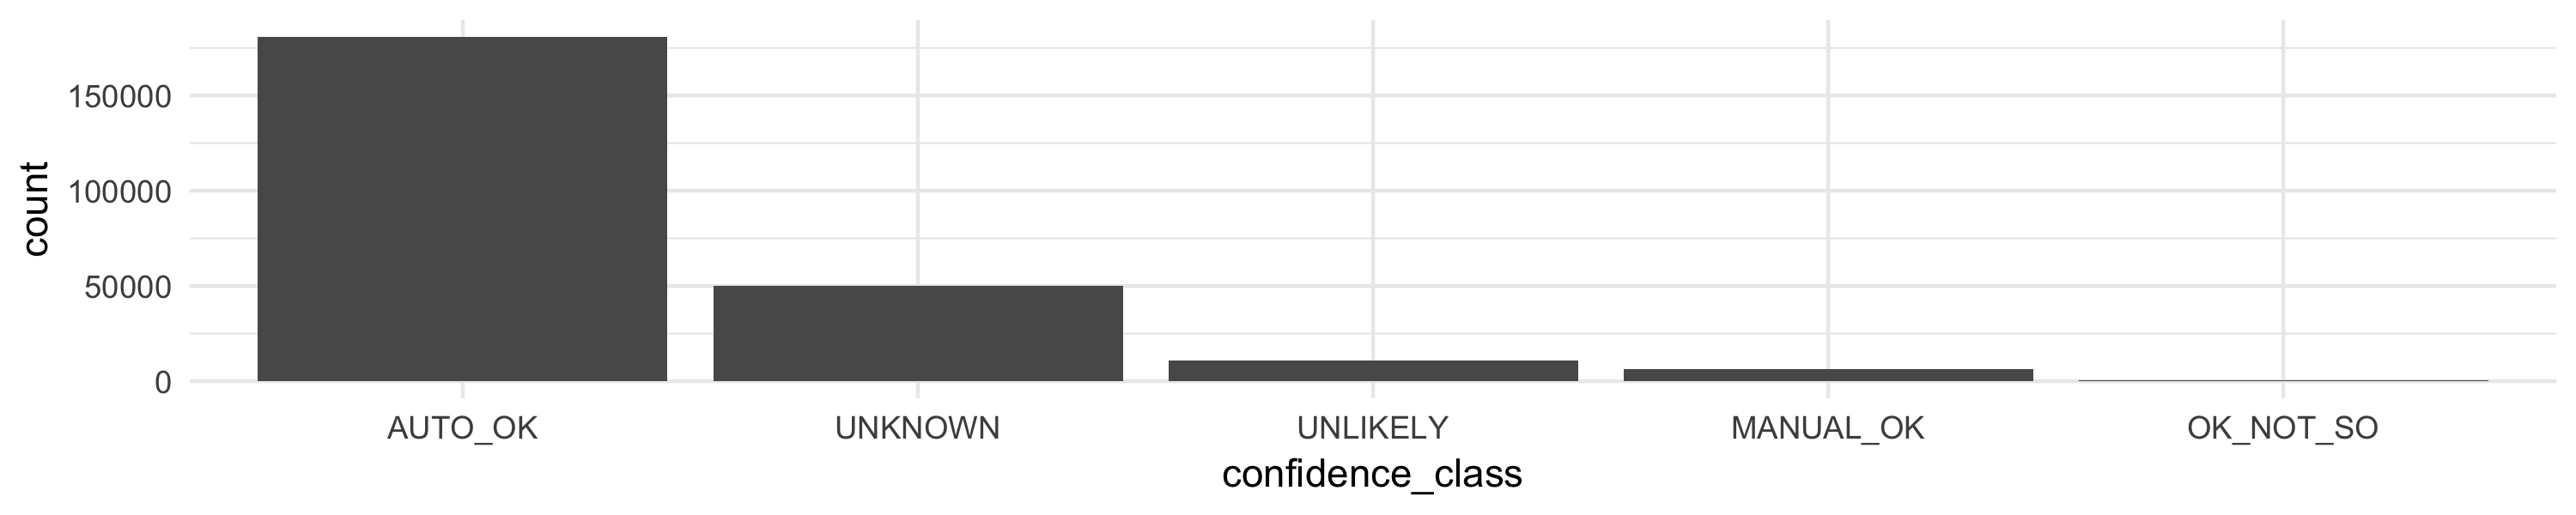

In [48]:
get_table(impact$confidence_class)
plot_histogram(impact, "confidence_class", height = 2)

### `Variant_Type`

In [49]:
unique(impact$Variant_Type)

[1] "SNP" "DEL" "INS" "DNP" "TNP"

The different types are:
* `DEL`: Deletion
* `INS`: Insertion
* `SNP`: Single Nucleotide Polymorphism
* `DNP`: Di-nucleotide Polymorphism
* `TNP`: Tri-nucleotide Polymorphism  

Let's study the number of rows in each category:

values,count,freq
SNP,214016,86.1%
DEL,23550,9.5%
INS,7865,3.2%
DNP,2878,1.2%
TNP,193,0.1%
-- total --,248502,100%


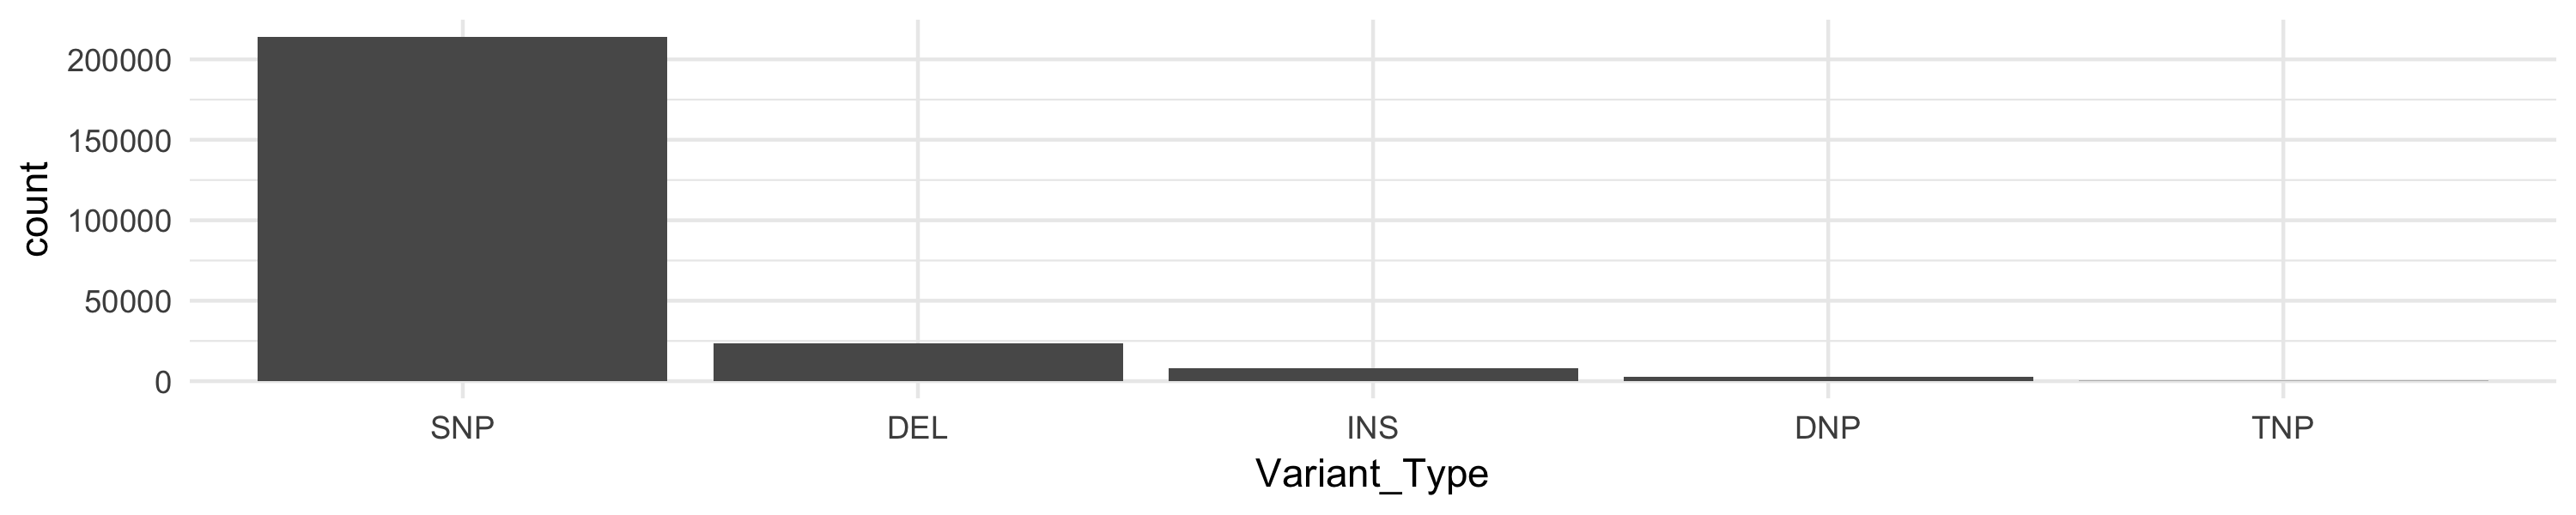

In [50]:
get_table(impact$Variant_Type)
plot_histogram(impact, "Variant_Type", height = 2)

###  `occurence_in_normals`

From `FirstLook.Rmd [Elsa]`: "Each variant is evaluted in ~15 run-specific normals + 20 fixed normals. Unfortunately we only have the mixed information for now. And we only have the count in the normals, no VAF or other info."

In [51]:
head(unique(impact$occurence_in_normals), 10)

# find the non-matching patterns
unique(impact$occurence_in_normals[grep(pattern = "+;+", impact$occurence_in_normals, invert = TRUE)])
nrow(impact[impact$occurence_in_normals == '0',])

[1] "0"       "0;0"     "1;0.026" "6;0.158" "3;0.079" "4;0.105" "7;0.184"
 [8] "2;0.051" "6;0.154" "3;0.077"

[1] "0"

[1] 97073

The format is `'count;frequency'` or `'0'` (97,452 samples). We consider the samples having `'0'` to have a frequency of 0, e.g. being `'0;0'`. Then, we extract the frequency part as a double, and replace the `occurence_in_normals` feature by the `frequency_in_normals` feature.

In [52]:
impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                      function(s) as.double(strsplit(s, split = ';')[[1]][2]))
impact$occurence_in_normals <- NULL
head(unique(impact$frequency_in_normals), 10)

[1] 0.000 0.026 0.158 0.079 0.105 0.184 0.051 0.154 0.077 0.103

In [53]:
summary(impact$frequency_in_normals != 0)
summary(impact$frequency_in_normals[impact$frequency_in_normals != 0])

   Mode   FALSE    TRUE 
logical  243217    5285 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01800 0.02300 0.04400 0.06718 0.09100 1.00000 

Overall the frequency of the apparition in normal samples is amost always null, except for a few rows (5393). For these last 5393 rows, the values are quite low ($\leq0.2$), except for a few outliers: see under the 14 mutations with a really high apparition in normal frequency (most of them have been curated as `UNLIKELY`, and 2 as `OK_NOT_SO` as expected).

In [54]:
impact$frequency_in_normals[impact$frequency_in_normals > 0.2]
get_table(impact[impact$frequency_in_normals > 0.2,]$confidence_class)

[1] 0.911 1.000 1.000 0.889 1.000 1.000 1.000 0.964 1.000 1.000 1.000 0.966
[13] 1.000 1.000

values,count,freq
UNLIKELY,12,85.7%
OK_NOT_SO,2,14.3%
-- total --,14,100%


Distribution of `frequency_in_normals` (warning this plot concerns only the non-null `frequency_in_normals` ie 2.13% of the data):

[1] "5285 over 248502 (2.13%)"

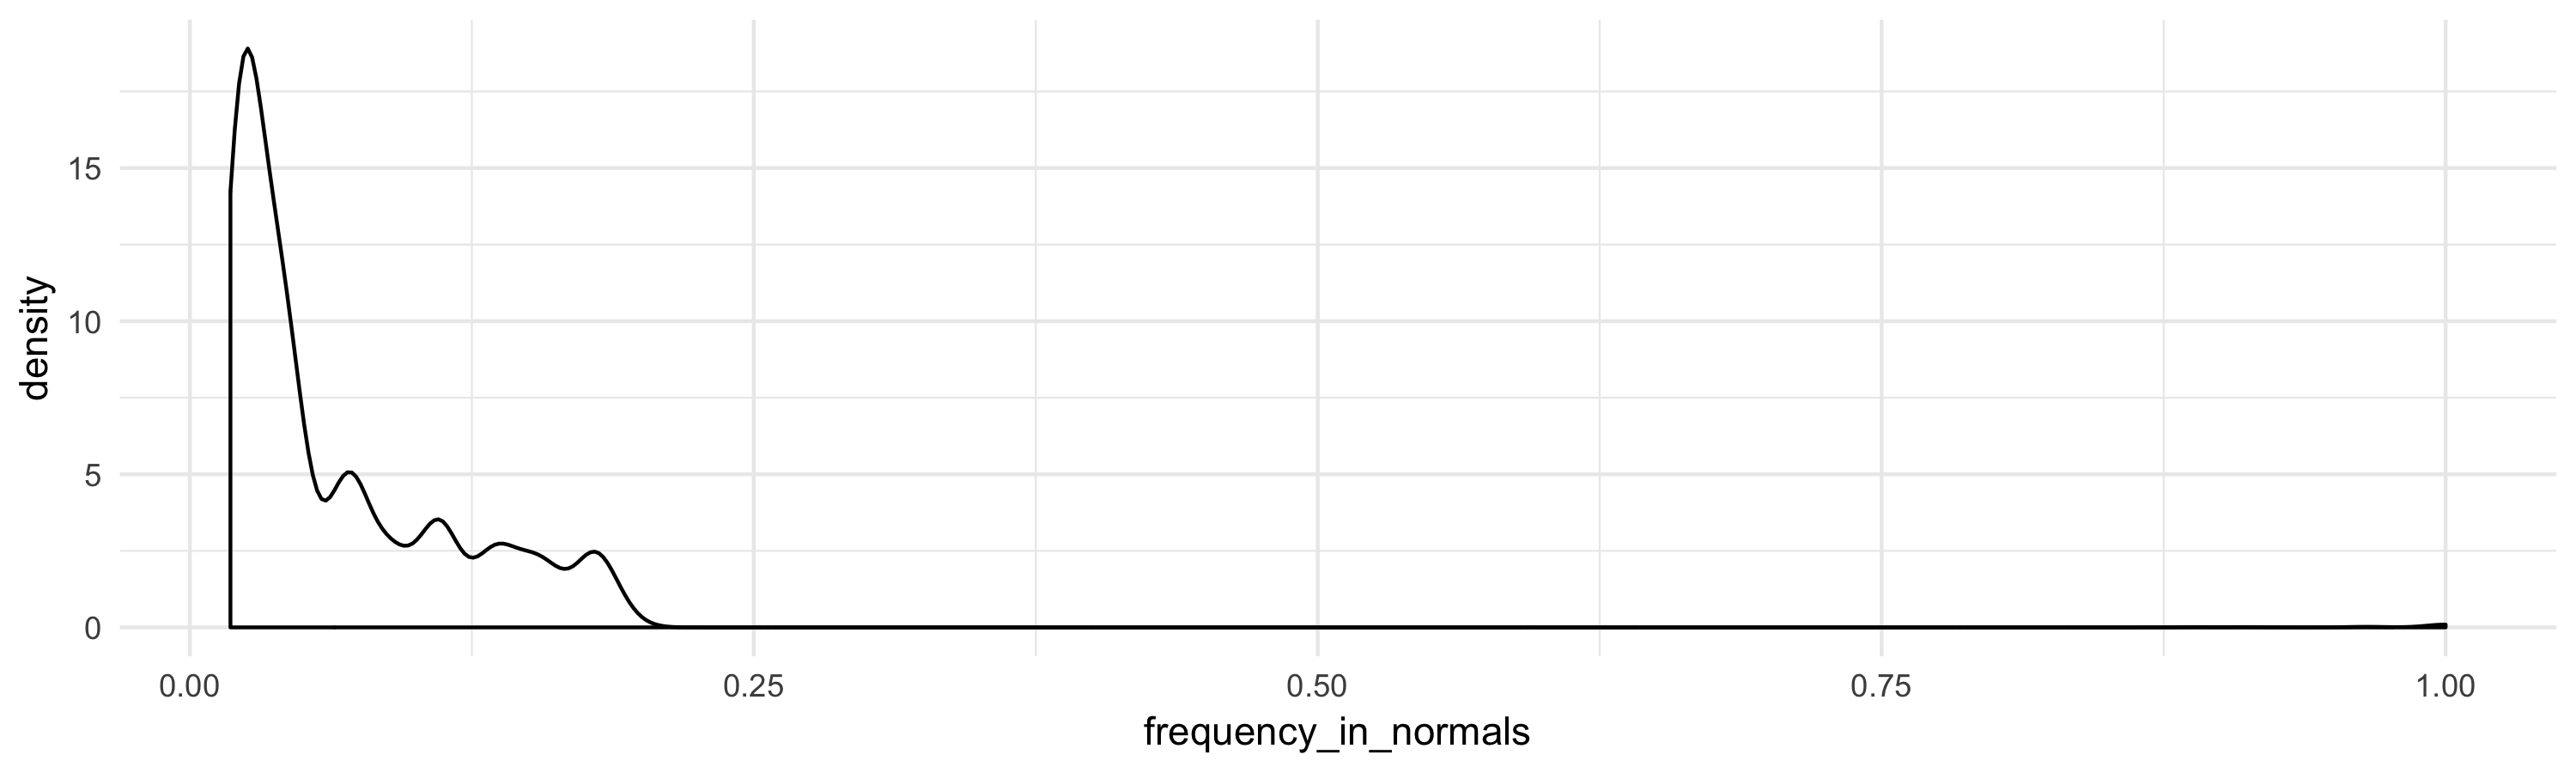

In [55]:
print_count_and_proportion(nrow(impact[impact$frequency_in_normals != 0,]), nrow(impact))
plot_density(impact[impact$frequency_in_normals != 0,], "frequency_in_normals")

Having a non-0 `frequency_in_normals` value doesn't seem to depend/influe on the gene, `confidence_class`, `Variant_Type` or `Consequence` features:

[1] "Number of different genes:  428"


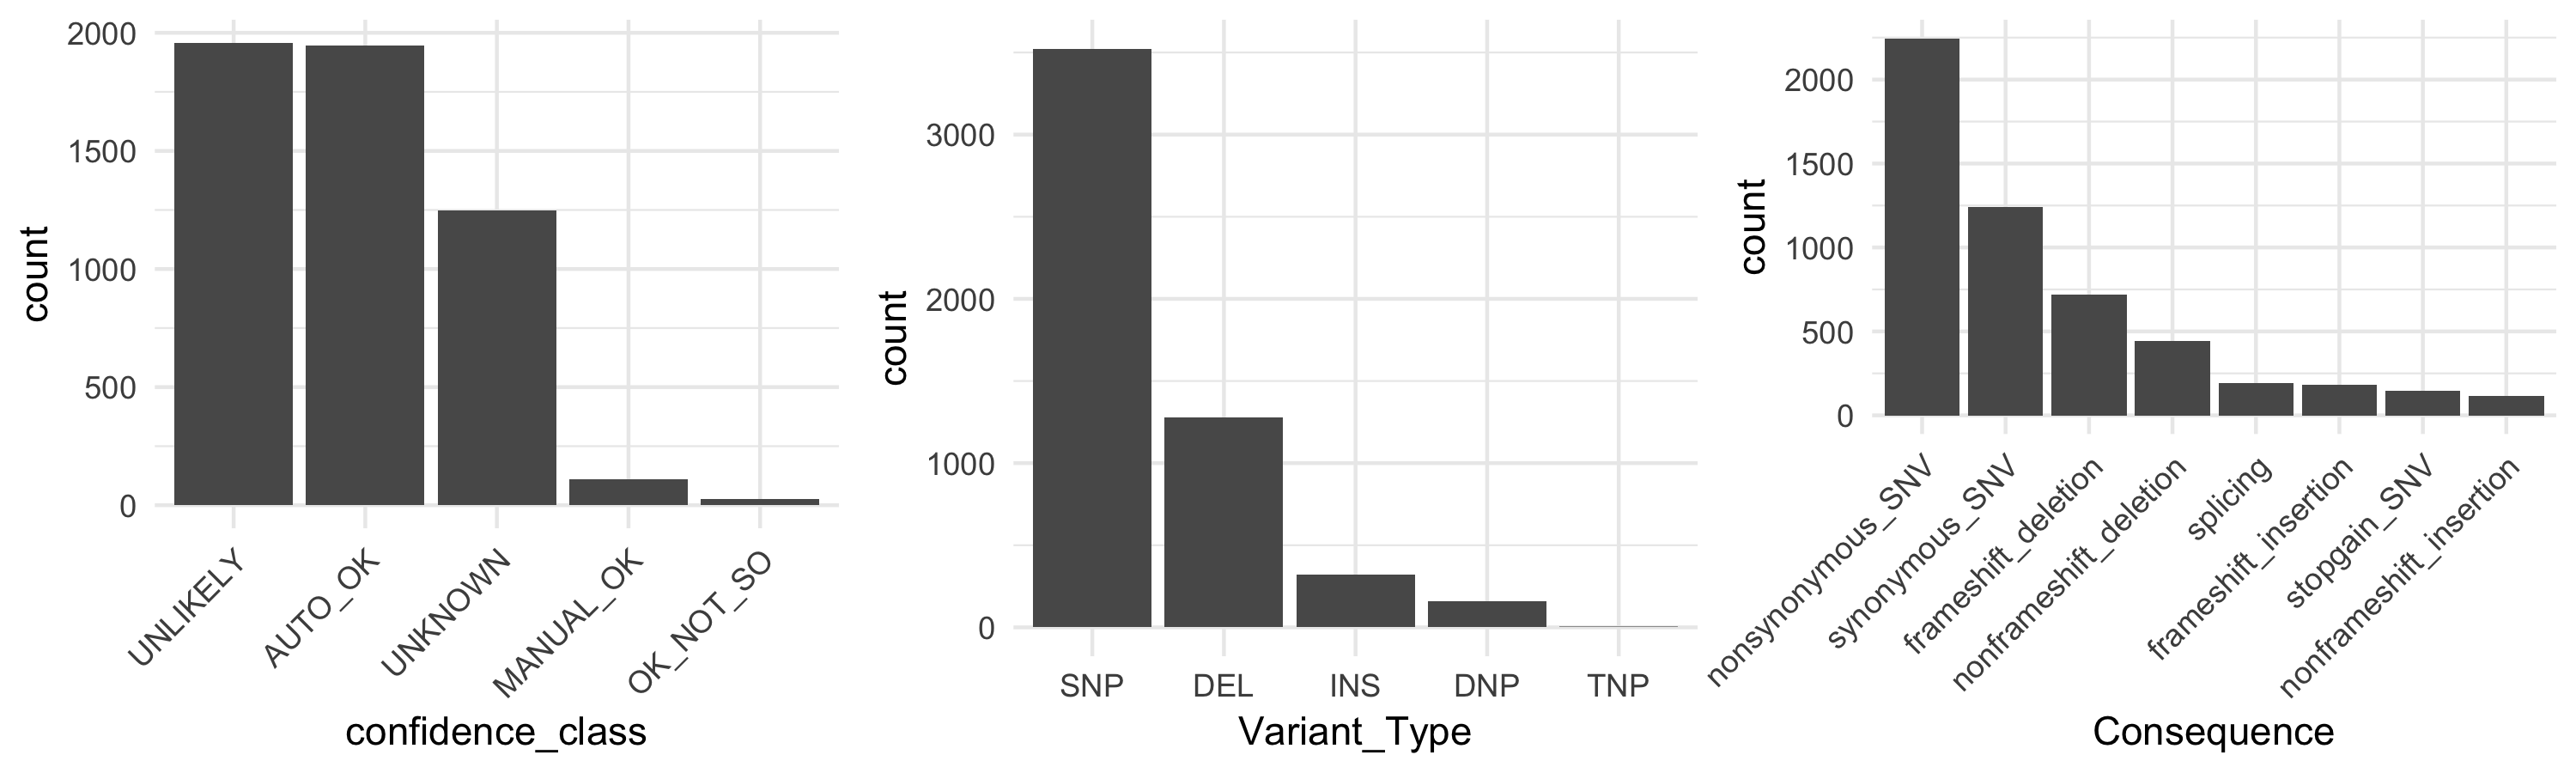

In [56]:
get_possible_correlations(impact[impact$frequency_in_normals > 0,])

### `sample_coverage`

In [57]:
summary(impact$sample_coverage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   47.0   574.0   722.0   722.3   863.0  2778.0 

In [58]:
# get the number n of unique sample_coverage values per Tumor_Sample_Barcode, count the rows where n != 1
nrow(impact %>% group_by(Tumor_Sample_Barcode) %>%
                summarise(n = length(unique(sample_coverage))) %>%
                filter(n != 1))

[1] 0

This shows that the `sample_coverage` feature is not a row dependant feature but a feature for each `Tumor_Sample_Barcode`, e.g. each tumor sample. It is an indicator of quality, for a definition see the [Coverage Wikipedia article](https://en.wikipedia.org/wiki/Coverage_%28genetics%29):  
"It is defined as
$$\text{coverage}\ =\ \frac{\text{number of reads}\times \text{average read length}}{\text{length of the genome covered}}$$  
For example, a hypothetical genome with 2,000 base pairs reconstructed from 8 reads with an average length of 500 nucleotides will have a sample_coverage of 2 (2× redundancy)."

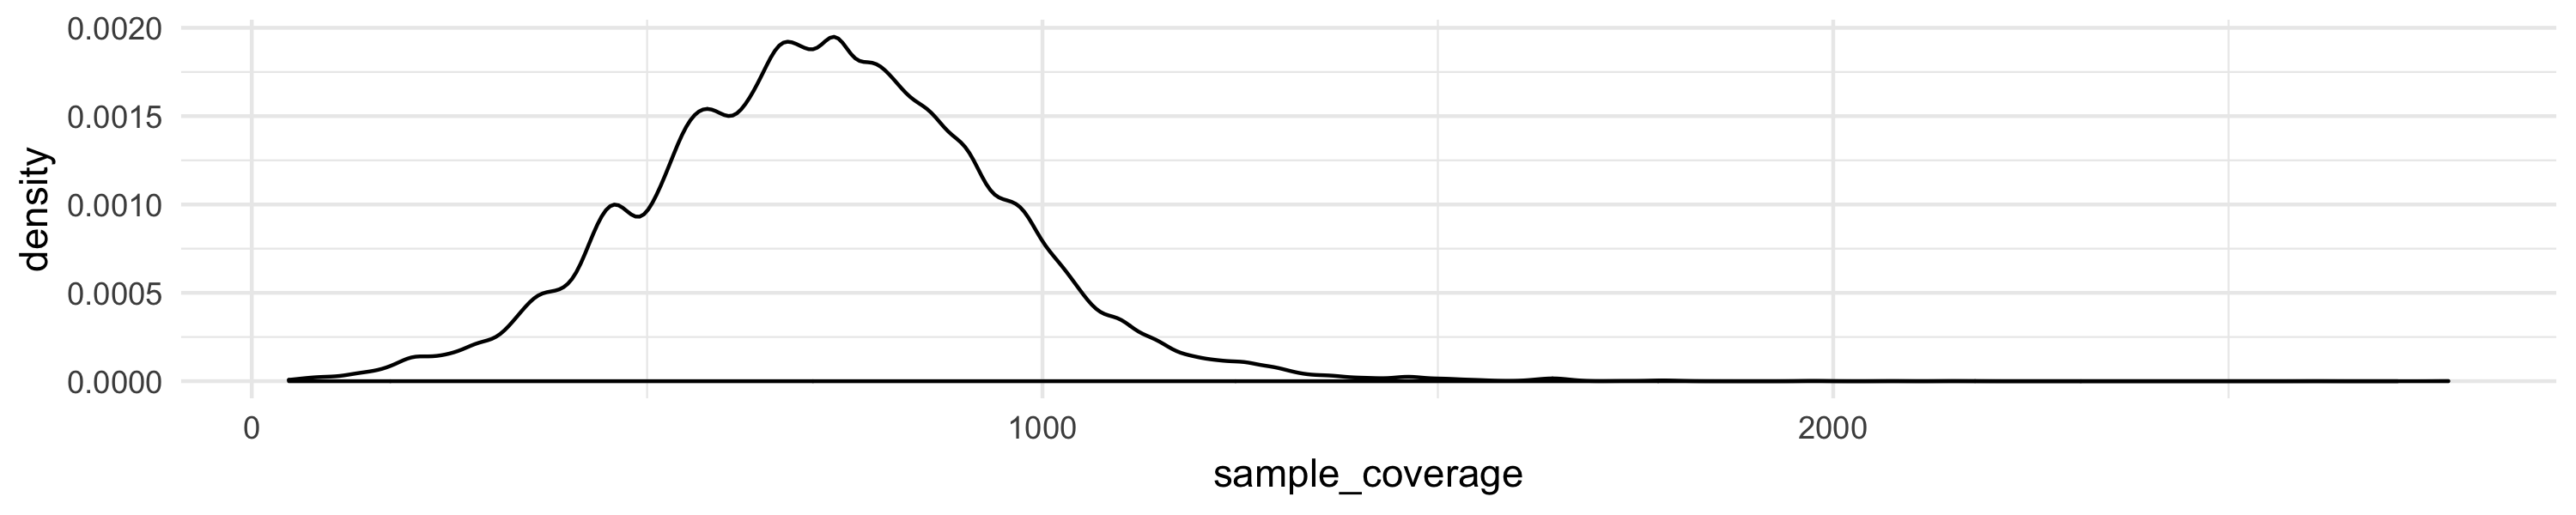

In [59]:
plot_density(impact, "sample_coverage", height = 2)

## Contingency tables

### `Consequence` vs `confidence_class`

The following plots represent the distribution of the mutations grouped by `Consequence` over the `confidence_class`. The left plot shows the count over each `confidence_class`, while the right plot shows the frequency over each `confidence_class`.

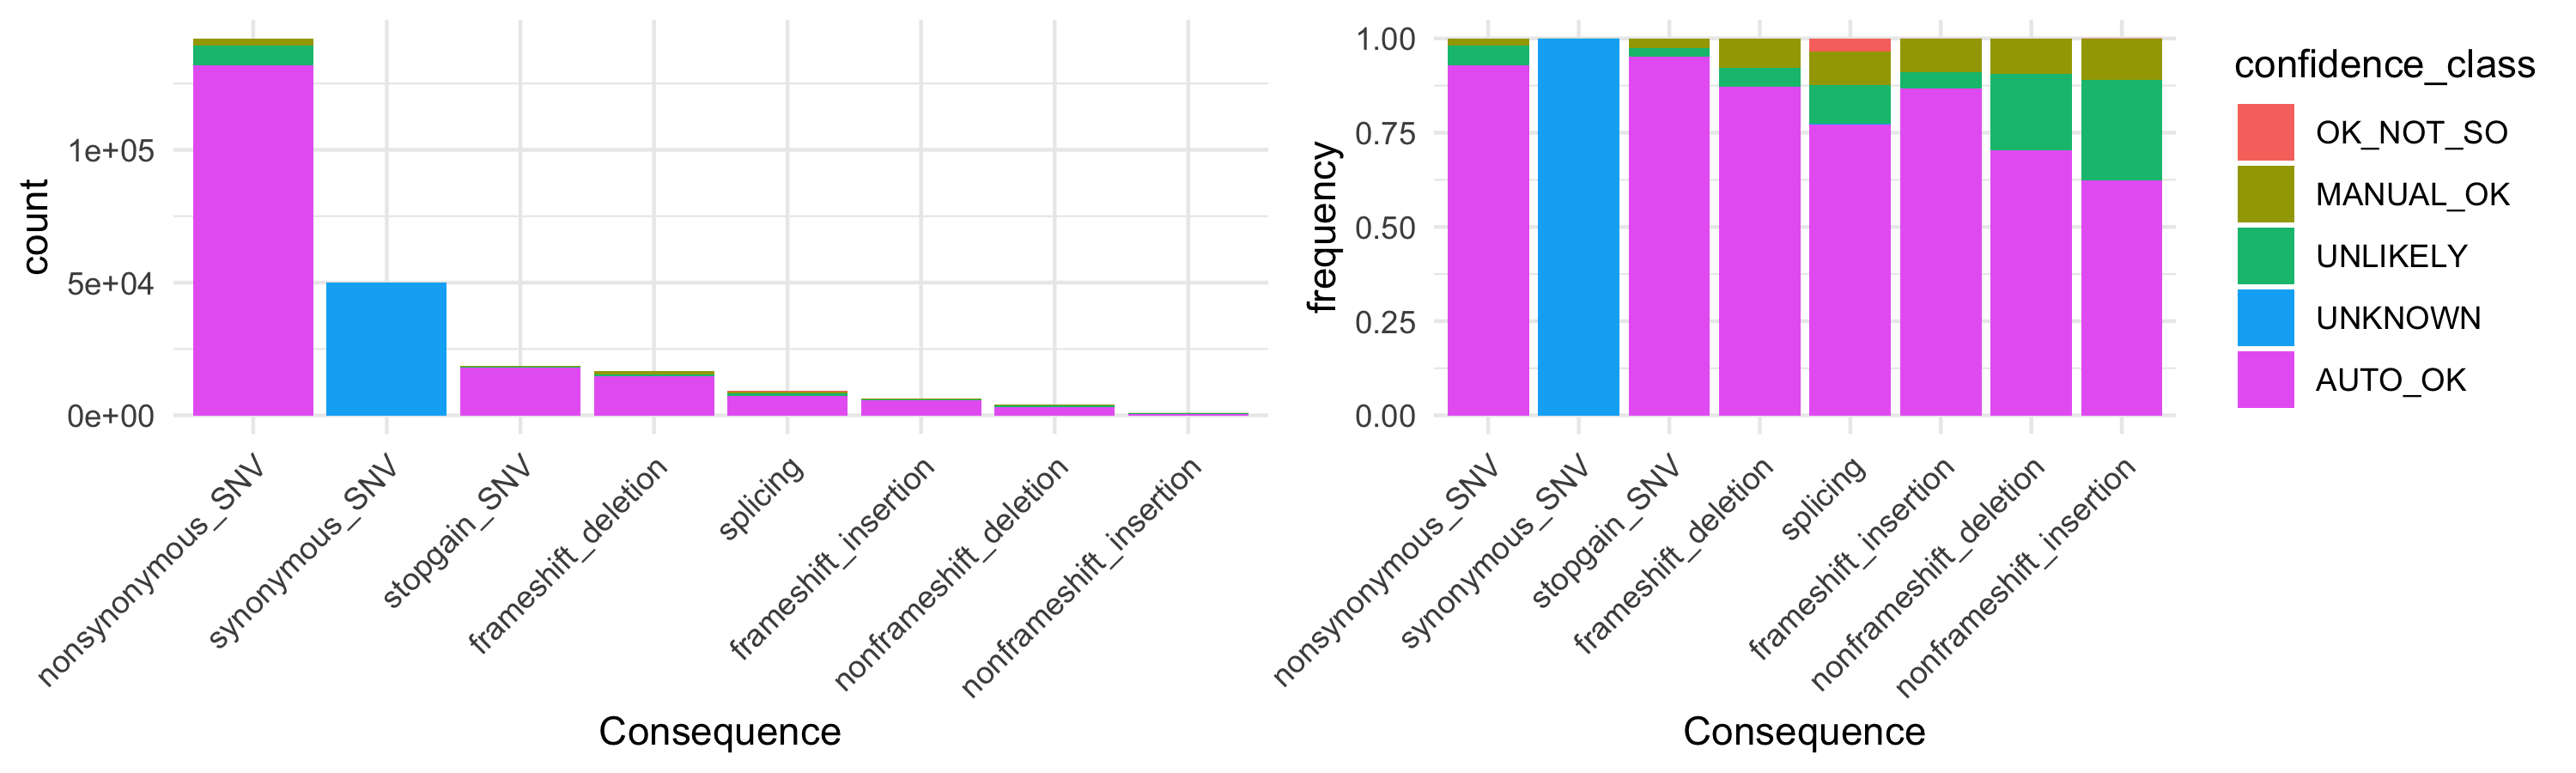

In [60]:
plot_contingency_table_as_histograms(impact, "Consequence", "confidence_class")

We see two things:
* the major part of the coding mutations are classified as `AUTO_OK` (we had already seen it before in the notebook)
* all `synonymous_SNV` mutations seem automatically classified as `UNKNOWN`, except 24 classified as `UNLIKELY`

In [61]:
get_table(impact[impact$Consequence == "synonymous_SNV",]$confidence_class)

values,count,freq
UNKNOWN,49986,100%
UNLIKELY,24,0%
-- total --,50010,100%


See [MSK-IMPACT 2015 article](https://www.sciencedirect.com/science/article/pii/S1525157815000458?via%3Dihub):  
* **Material and Methods/Filtering for High-Confidence SNVs and Indels/Filtering Based on Location and Effect of Variants, p.255**: "[...] non-exonic variants [...] were directed to a separate output file (intronic, untranslated region, intergenic, upstream) [...] Synonymous (ie, silent) exonic variants were similarly redirected."

For consistancy we will classify all the `synonymous_SNV` as `UNKNOWN`:

In [62]:
impact$confidence_class[impact$Consequence == "synonymous_SNV"] <- "UNKNOWN"

### `Consequence` vs `Variant_Type`

The following plots represent the distribution of the mutations grouped by `Consequence` over the `Variant_Type`:

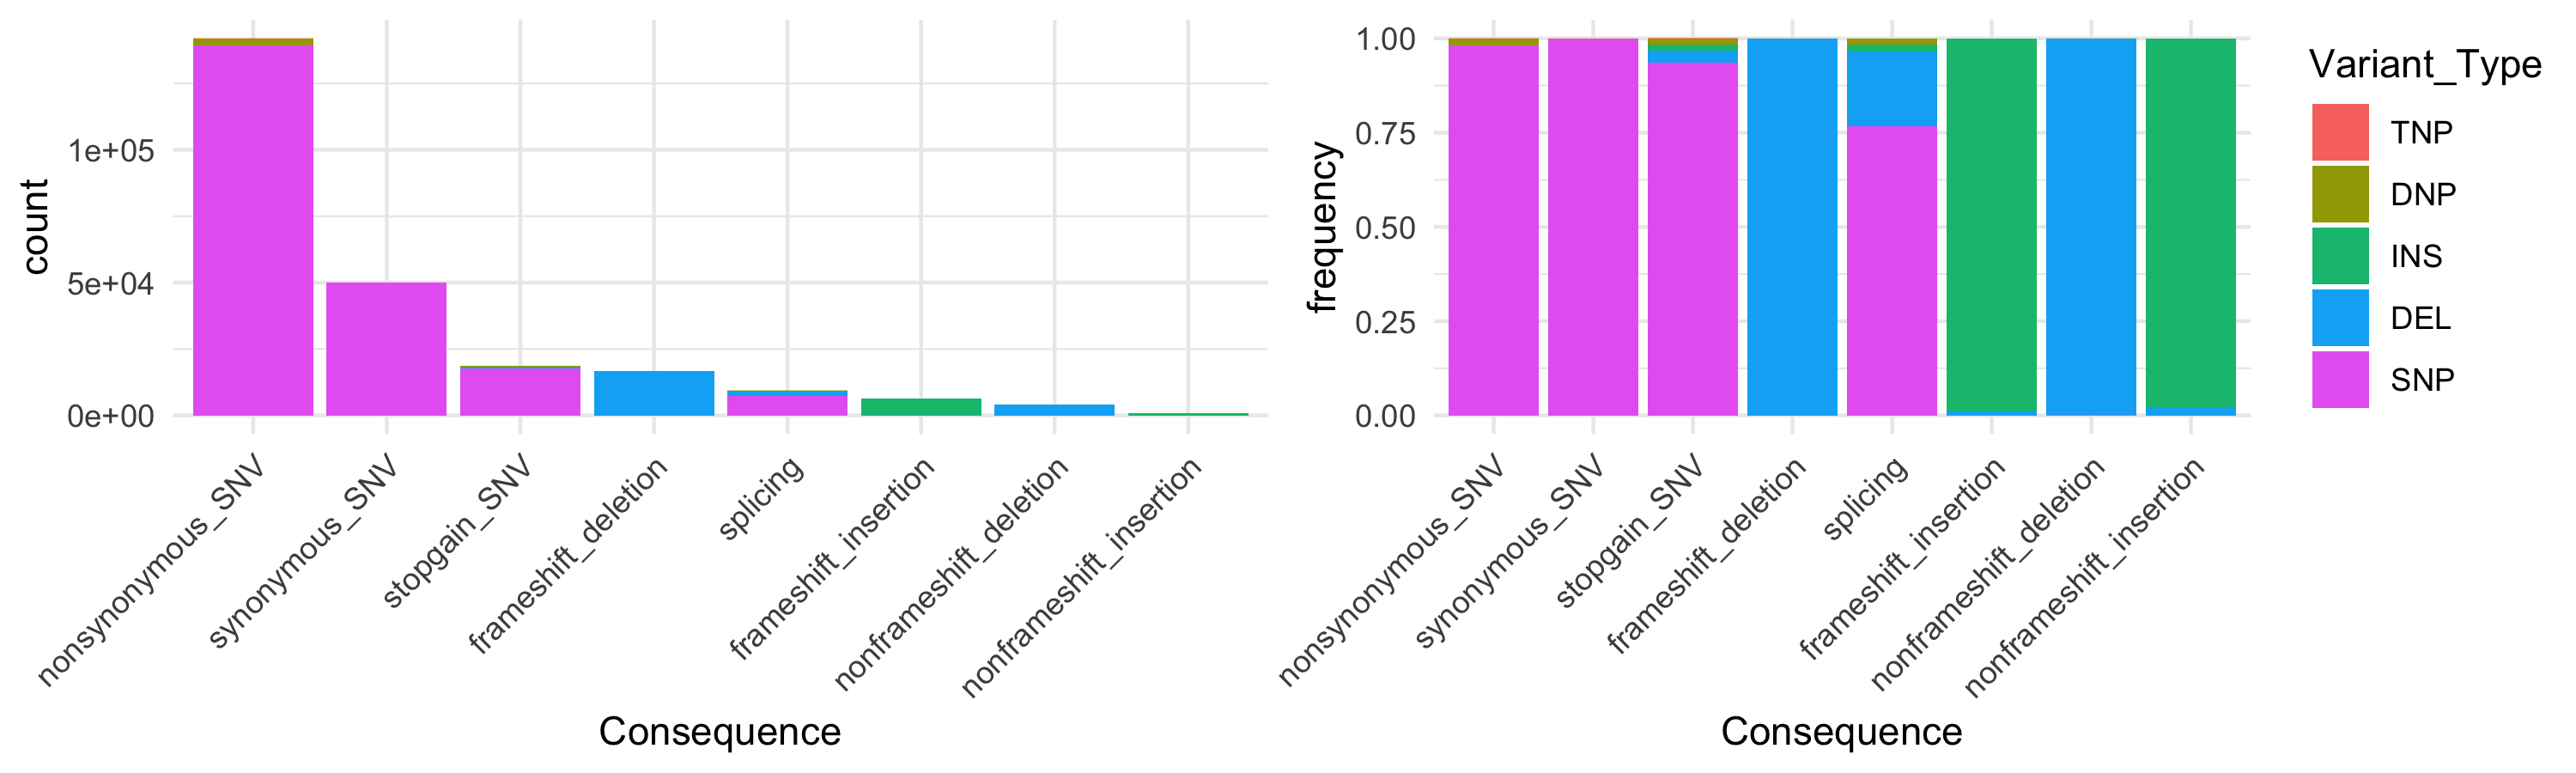

In [63]:
plot_contingency_table_as_histograms(impact, "Consequence", "Variant_Type")

The major part of the mutations are of type `SNP` (we had already seen it before in the notebook). However, it seems that there are a few contradictions in the dataset concerning the frameshift/non-frameshift insertion/deletion, as well as the `nonsynonymous_SNV` mutations. For example, some `frameshift_insertion` have a `DEL` `Variant_Type`.

<font color='red'> ?? Where do these errors come from? See `first_analysis_unsolved_issues.ipynb` for more information.  
    
**Decision:** we decided to reclassify the wrongly classified mutations over the `Consequence` feature. It is now consistant with `Variant_Type` and `HGVSp_Short`. The modification are present in the last summary part. </font>

### `Variant_Type` vs `confidence_class`

The following plots represent the distribution of the mutations grouped by `Variant_Type` over the `confidence_class`:

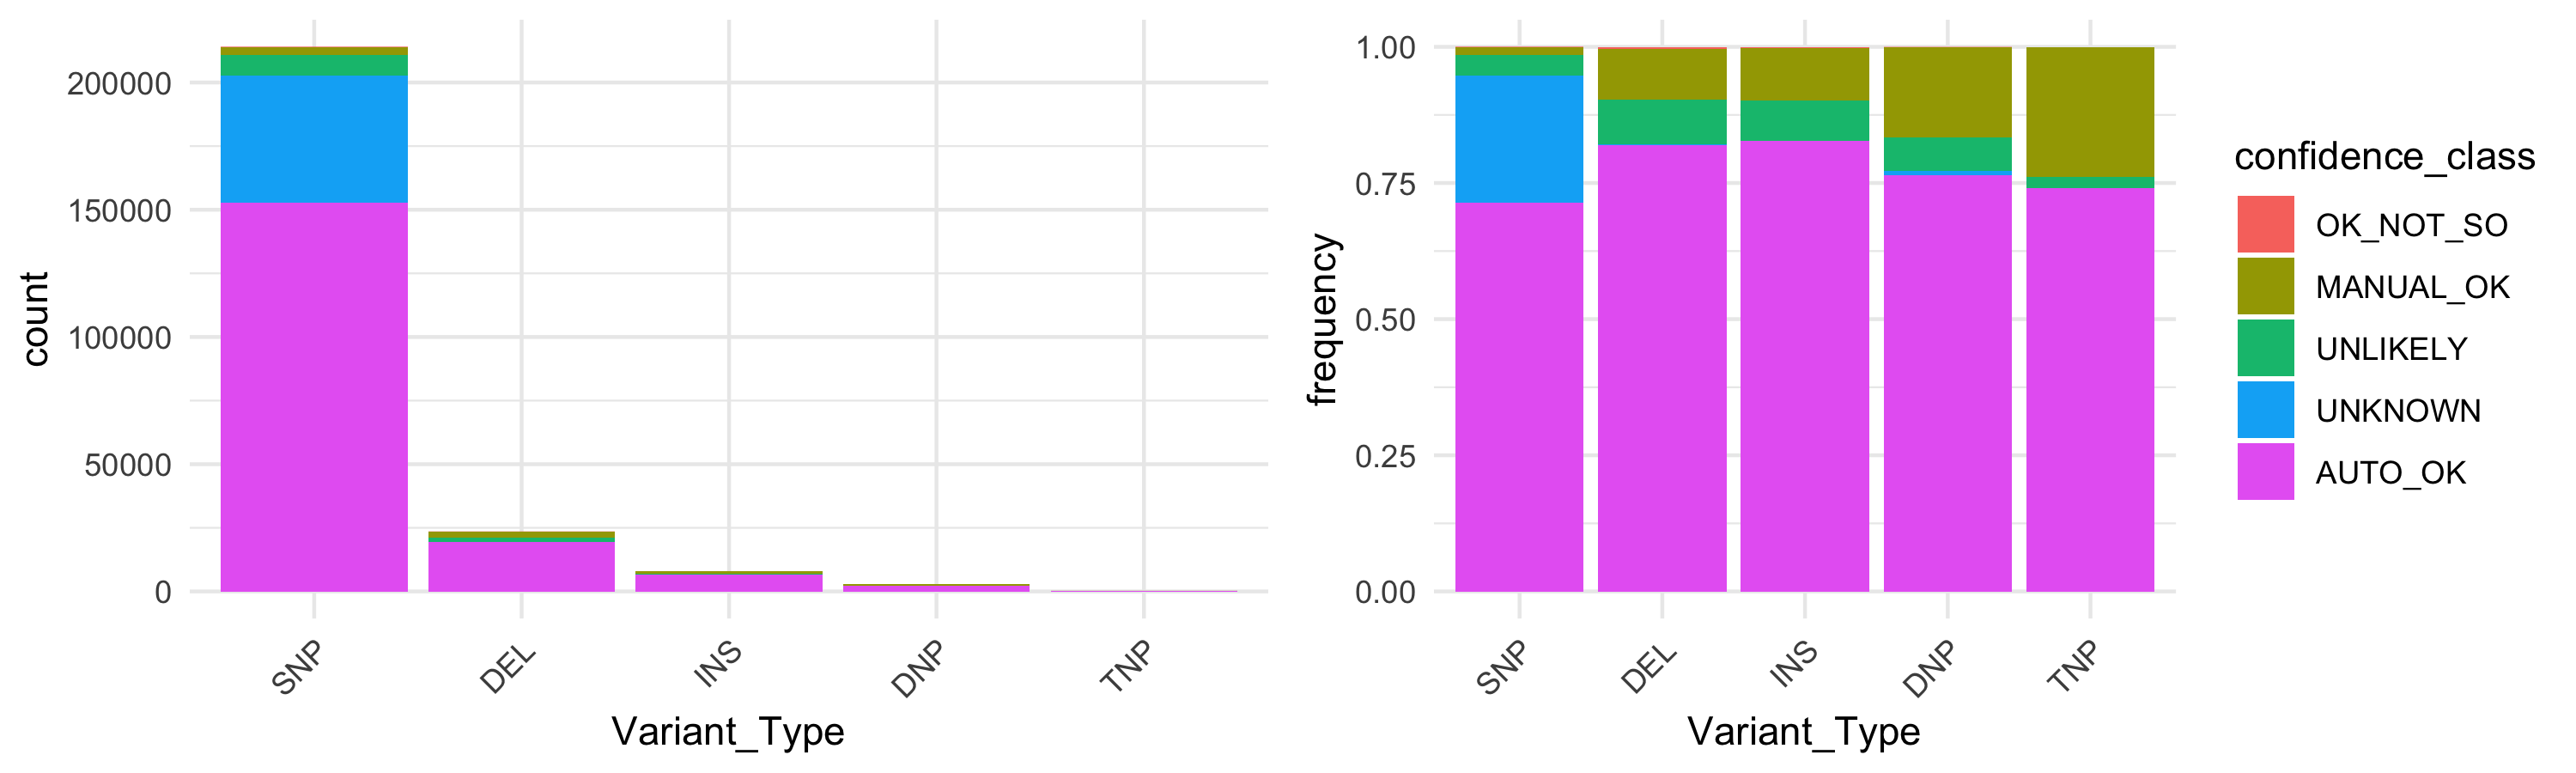

In [64]:
plot_contingency_table_as_histograms(impact, "Variant_Type", "confidence_class")

Nothing particularly interesting was found here.

## Resume of the operations needed to clean the dataset

The following function `get_cleaned_impact()` applies all the above filterings to the raw dataset, it will be added to `custom_tools.R`, as well as the `selected_mutation_types` vector.

In [65]:
# ~ stands for "modify"
get_cleaned_impact <- function(data_folder_name) {

  # [+35 features, +588,547 rows] get the original dataset
  impact <- read.table(paste0(data_folder_name, "/all_IMPACT_mutations_180508.txt"),
                       sep = "\t", stringsAsFactors = FALSE, header = TRUE)


  # [-7 features] remove the unique-value features
  impact[, c("Entrez_Gene_Id",
             "Center",
             "NCBI_Build",
             "Strand",
             "dbSNP_RS",
             "Matched_Norm_Sample_Barcode",
             "variant_status")] <- list(NULL)


  # [-3 features] remove the redundant features
  impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- list(NULL)


  # [-322,796 rows] remove the non-interesting mutations
  impact <- impact[impact$Consequence %in% c("stopgain_SNV",
                                             "splicing",
                                             "nonsynonymous_SNV",
                                             "nonframeshift_insertion",
                                             "nonframeshift_deletion",
                                             "frameshift_insertion",
                                             "frameshift_deletion",
                                             "synonymous_SNV"),]


  # [-12,975 rows] remove the contaminated rows
  impact <- impact[impact$minor_contamination <= 0.01,]
  # [-1 feature] remove the minor_contamination feature
  impact["minor_contamination"] <- NULL


  # [-373 rows] remove the rows having n_depth < 20
  impact <- impact[impact$n_depth >= 20,]


  # [-46 rows] remove the rows having impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count
  impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]


  # [+1 feature] create a mutation key feature to idenfity unique mutations
  impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
  # [+1 feature] create a sample mutation key feature to idenfity unique rows
  impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')


  # [~7501 rows] replace the wrong Hugo symbols with the good ones
  old_Hugo_Symbol = c('MLL3', 'PAK7', 'RFWD2', 'MYCL1', 'MLL2', 'MLL', 'FAM46C', 'MRE11A', 'PARK2', 'FAM175A',
                      'TCEB1', 'WHSC1', 'WHSC1L1', 'FAM58A', 'SETD8', 'MLL4')
  new_Hugo_Symbol = c('KMT2C', 'PAK5', 'COP1', 'MYCL', 'KMT2D', 'KMT2A', 'TENT5C', 'MRE11', 'PRKN', 'ABRAXAS1',
                      'ELOC', 'NSD2', 'NSD3', 'CCNQ', 'KMT5A', 'KMT2B')
  old_symbols <- which(impact$Hugo_Symbol %in% old_Hugo_Symbol)
  impact$Hugo_Symbol[old_symbols] <- new_Hugo_Symbol[match(impact$Hugo_Symbol[old_symbols], old_Hugo_Symbol)]
  # [~1334 rows] replace "CDKN2Ap16INK4A" by "CDKN2A"
  impact$Hugo_Symbol[impact$Hugo_Symbol == "CDKN2Ap16INK4A"] <- "CDKN2A"
  # [-808 rows] delete the "CDKN2Ap14ARF" already read in the classic read frame (in "CDKN2Ap16INK4A")
  impact <- impact %>% filter(! (Hugo_Symbol == "CDKN2Ap14ARF" & mut_key %in% impact$mut_key[impact$Hugo_Symbol == "CDKN2A"]))


  # [-2979 rows] remove the hypermutated patient
  impact <- impact[impact$Tumor_Sample_Barcode != "P-0025368-T01-IM6",]


  # [-57 rows] remove the duplicated mutations
  impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
  impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth))
  impact_redundant_to_delete <- impact_redundant_to_delete %>% group_by(sample_mut_key) %>% filter(t_vaf == min(t_vaf))
  impact <- impact %>% filter(! (sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                                 t_depth %in% impact_redundant_to_delete$t_depth &
                                 t_vaf %in% impact_redundant_to_delete$t_vaf))


  # [~ every rows] replace the occurence_in_normals feature by frequency_in_normals
  impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
  impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                        function(s) as.double(strsplit(s, split = ';')[[1]][2]))
  impact$occurence_in_normals <- NULL


  # [~24 rows] set all the `synonymous_SNV` as "UNKNOWN" for consistancy (24 were classified as "UNLIKELY")
  impact$confidence_class[impact$Consequence == "synonymous_SNV"] <- "UNKNOWN"


  # [-4 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
  impact <- impact[! impact$sample_mut_key %in% c("P-0002209-T02-IM5_19_13051633_G_A",
                                                  "P-0002955-T01-IM3_11_108143466_A_T",
                                                  "P-0005565-T01-IM5_17_2225414_ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG_CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG",
                                                  "P-0019100-T01-IM6_5_112175190_ATA_ACA"),]
  # [~6 rows] reclassify the mutations to `nonsynonymous_SNV` based on Variant_Type
  impact$Consequence[impact$sample_mut_key %in% c("P-0004486-T01-IM5_1_120468201_A_T",
                                                  "P-0003132-T01-IM5_15_41988433_G_A",
                                                  "P-0009326-T01-IM5_17_74732956_G_A",
                                                  "P-0010818-T01-IM5_17_74732956_G_A",
                                                  "P-0012684-T01-IM5_17_7578254_CT_AA",
                                                  "P-0010818-T02-IM6_17_74732956_G_A")] <- "nonsynonymous_SNV"
  # [~311 rows] reclassify the mutations to frameshift/nonframeshift insertion/deletion based on Variant_Type
  consequence_to_reclassify <- c("nonsynonymous_SNV", "frameshift_insertion", "frameshift_deletion",
                                 "nonframeshift_insertion", "nonframeshift_deletion")
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "INS"] <- "frameshift_insertion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "DEL"] <- "frameshift_deletion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "INS"] <- "nonframeshift_insertion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "DEL"] <- "nonframeshift_deletion"


  to_replace <- as.vector(read.table(paste0(data_folder_name, "/utils/sample_mut_keys_to_remove.txt"),
                                     sep = "\t", stringsAsFactors = FALSE)[[1]])
  replace_Consequence <- read.table(paste0(data_folder_name, "/utils/replace_Consequence.txt"),
                                    sep = "\t", stringsAsFactors = FALSE)
  colnames(replace_Consequence) <- c("key", "new")
  replace_HGVSp_Short <- read.table(paste0(data_folder_name, "/utils/replace_HGVSp_Short.txt"),
                                    sep = "\t", stringsAsFactors = FALSE)
  colnames(replace_HGVSp_Short) <- c("key", "new")
  # [-148 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
  impact <- impact[! impact$sample_mut_key %in% to_replace,]
  # [~1004 rows] reclassify the mutations `Consequence` based on HGVSp_Short
  to_replace <- which(impact$sample_mut_key %in% replace_Consequence$key)
  impact[to_replace,] <- impact[to_replace,] %>%
                         group_by(sample_mut_key) %>%
                         mutate(Consequence = as.vector(replace_Consequence$new[replace_Consequence$key == sample_mut_key]))
  # [~32 rows] correct the HGVSp_Short typos
  to_replace <- which(impact$sample_mut_key %in% replace_HGVSp_Short$key)
  impact[to_replace,] <- impact[to_replace,] %>%
                         group_by(sample_mut_key) %>%
                         mutate(HGVSp_Short = as.vector(replace_HGVSp_Short$new[replace_HGVSp_Short$key == sample_mut_key]))
  

  to_replace <- as.vector(read.table(paste0(data_folder_name, "/utils/mut_keys_to_remove.txt"),
                                     sep = "\t", stringsAsFactors = FALSE)[[1]])
  replace_Consequence <- read.table(paste0(data_folder_name, "/utils/replace_Consequence_2.txt"),
                                     sep = "\t", stringsAsFactors = FALSE)
  colnames(replace_Consequence) <- c("key", "new")
  replace_HGVSp_Short <- read.table(paste0(data_folder_name, "/utils/replace_HGVSp_Short_2.txt"),
                                     sep = "\t", stringsAsFactors = FALSE)
  colnames(replace_HGVSp_Short) <- c("key", "new")
  # [-57 rows] remove the mutations having inconsistent and contradictory HGVSp_Short
  impact <- impact[! impact$mut_key %in% to_replace,]
  # [~41 rows] correct the inconsistent Consequence values
  to_replace <- which(impact$mut_key %in% replace_Consequence$key)
  impact[to_replace,] <- impact[to_replace,] %>%
                         group_by(mut_key) %>%
                         mutate(Consequence = as.vector(replace_Consequence$new[match(mut_key, replace_Consequence$key)]))
  # [~1153 rows] correct the inconsistent HGVSp_Short values
  to_replace <- which(impact$mut_key %in% replace_HGVSp_Short$key)
  impact[to_replace,] <- impact[to_replace,] %>%
                         group_by(mut_key) %>%
                         mutate(HGVSp_Short = as.vector(replace_HGVSp_Short$new[match(mut_key, replace_HGVSp_Short$key)]))


  return (impact)
}

In [66]:
impact <- get_cleaned_impact("../../../data")
ncol(impact) # 35 before
nrow(impact) # 588,547 before

[1] 26

[1] 248293

Compute the main results:

In [67]:
# number of mutations
nrow(impact)
# percentage of synonymous
100 * nrow(impact[impact$Consequence == "synonymous_SNV",]) / nrow(impact)

[1] 248293

[1] 20.13951

In [68]:
# number of tumor samples
length(unique(impact$Tumor_Sample_Barcode))
# mean number of mutations per sample
mean(table(impact$Tumor_Sample_Barcode))

[1] 22990

[1] 10.80004

In [69]:
# number of patients
length(unique(substr(impact$Tumor_Sample_Barcode, 1, 9)))

[1] 21252

In [70]:
# number of genes
length(unique(impact$Hugo_Symbol))

[1] 475

In [71]:
# mean sample coverage
mean(impact$sample_coverage)

[1] 722.3015